# Recycling in Europe - Data Preprocessing Pipeline

This notebook processes and cleans multiple datasets related to recycling rates and environmental factors across European countries. The datasets are combined to create a unified dataset for analysis.

## Overview of Datasets:
- **D1**: General recycling rates (overall waste recycling %)
- **D2**: Recycling rates by waste type (glass, plastic, paper, metallic, wooden, packaging)
- **D3**: Socioeconomic indicators (GDP per capita, urbanization, internet usage, renewable energy, etc.)
- **CEI**: Circular economy indicators (private investments and output of circular economy sectors)
- **ENV**: Environmental tax revenues (as % of GDP)


# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D


In [2]:
MISSING_RATE = 0.9
EU_COUNTRIES = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 
    'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 
    'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 
    'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 
    'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 
    'Spain', 'Sweden'
]

# Preprocessing

## Functions

In [3]:
def fill_missing(series: pd.Series) -> pd.Series:
    # 1. interpolation for internal gaps
    # 2. backward fill for leading NaNs
    # 3. forward fill for trailing NaNs
    return series.interpolate().bfill().ffill()

## D1 - general recylcing rates

In [4]:
d1 = pd.read_csv("raw_data/d1.csv")

In [5]:
res_d1 = d1.copy()
res_d1 = res_d1[['geo', 'TIME_PERIOD', "OBS_VALUE", "OBS_FLAG"]]
res_d1 = res_d1.rename(columns={"geo": "country_name",
                                "TIME_PERIOD": "year",
                                "OBS_VALUE": "recycling_rate",
                                "OBS_FLAG": "flag"})
res_d1['country_name'] = res_d1['country_name'].astype("string")
res_d1['year'] = res_d1['year'].astype(int)
res_d1['recycling_rate'] = res_d1['recycling_rate'].astype(float)
res_d1['flag'] = res_d1['flag'].astype("string")

missing_rates_d1 = pd.DataFrame(res_d1.groupby("country_name")["recycling_rate"].apply(lambda x: x.isna().mean())).reset_index()
missing_rates_d1.to_csv("processed_data/missing_value_rates_d1.csv", index=False)

values_to_drop_d1 = []
for index, row in missing_rates_d1.iterrows():
    if row['recycling_rate'] > MISSING_RATE:
        values_to_drop_d1.append(row['country_name'])
res_d1 = res_d1[~res_d1['country_name'].isin(values_to_drop_d1)]
print(f"Dropped countries in d1 (n={len(values_to_drop_d1)}):", values_to_drop_d1)

res_d1['recycling_rate_filled'] = res_d1.groupby("country_name")["recycling_rate"].transform(fill_missing)

Dropped countries in d1 (n=1): ['Euro area – 20 countries (from 2023)']


In [6]:
res_d1.isna().sum()

country_name               0
year                       0
recycling_rate           134
flag                     755
recycling_rate_filled      0
dtype: int64

In [7]:
res_d1.to_csv("processed_data/preprocessed_d1.csv", index=False)

## D2 - different types of waste

In [8]:
d2 = pd.read_csv("raw_data/d2.csv")

In [9]:
res_d2 = d2.copy()
res_d2 = res_d2[['geo', 'TIME_PERIOD', 'waste', 'OBS_VALUE', 'OBS_FLAG']]
res_d2 = res_d2.rename(columns={"geo": "country_name",
                                "TIME_PERIOD": "year",
                                "waste": "waste_type",
                                "OBS_VALUE": "recycling_rate",
                                "OBS_FLAG": "flag"})
res_d2['country_name'] = res_d2['country_name'].astype("string")
res_d2['year'] = res_d2['year'].astype(int)
res_d2['waste_type'] = res_d2['waste_type'].astype("string")
res_d2['recycling_rate'] = res_d2['recycling_rate'].astype(float)
res_d2['flag'] = res_d2['flag'].astype("string")

missing_rates_d2 = pd.DataFrame(res_d2.groupby(["country_name", 'waste_type'])["recycling_rate"].apply(lambda x: x.isna().mean())).reset_index()
missing_rates_d2.to_csv("processed_data/missing_value_rates_d2.csv", index=False)

values_to_drop_d2 = set()
for index, row in missing_rates_d2.iterrows():
    country_name = row['country_name']
    waste_type = row['waste_type']
    rate = row['recycling_rate']
    if rate > MISSING_RATE:
        values_to_drop_d2.add(country_name)
        print(f"{country_name}\t{waste_type}")

res_d2 = res_d2[~res_d2['country_name'].isin(values_to_drop_d2)]
print(f"Dropped countries in d2 (n={len(values_to_drop_d2)}):", values_to_drop_d2)

res_d2['recycling_rate_filled'] = res_d2.groupby(["country_name", "waste_type"])["recycling_rate"].transform(fill_missing)

clean_names = {
    "Glass packaging": "glass",
    "Metallic packaging": "metallic",
    "Packaging": "packaging",
    "Paper and cardboard packaging": "paper",
    "Plastic packaging": "plastic",
    "Wooden packaging": "wooden"
}
res_d2['waste_type'] = res_d2['waste_type'].map(clean_names)

res_d2 = res_d2.pivot(index=['country_name', 'year'], columns='waste_type', values=['recycling_rate_filled', "recycling_rate", "flag"]).reset_index()
res_d2.columns = [f"{val}_{waste}" if waste else val for val, waste in res_d2.columns]

Albania	Glass packaging
Albania	Metallic packaging
Albania	Packaging
Albania	Paper and cardboard packaging
Albania	Plastic packaging
Albania	Wooden packaging
Euro area - 19 countries  (2015-2022)	Glass packaging
Euro area - 19 countries  (2015-2022)	Metallic packaging
Euro area - 19 countries  (2015-2022)	Packaging
Euro area - 19 countries  (2015-2022)	Paper and cardboard packaging
Euro area - 19 countries  (2015-2022)	Plastic packaging
Euro area - 19 countries  (2015-2022)	Wooden packaging
Euro area – 20 countries (from 2023)	Glass packaging
Euro area – 20 countries (from 2023)	Metallic packaging
Euro area – 20 countries (from 2023)	Packaging
Euro area – 20 countries (from 2023)	Paper and cardboard packaging
Euro area – 20 countries (from 2023)	Plastic packaging
Euro area – 20 countries (from 2023)	Wooden packaging
Montenegro	Glass packaging
Montenegro	Metallic packaging
Montenegro	Packaging
Montenegro	Paper and cardboard packaging
Montenegro	Plastic packaging
Montenegro	Wooden packag

In [10]:
res_d2.isna().sum()

country_name                         0
year                                 0
recycling_rate_filled_glass          0
recycling_rate_filled_metallic       0
recycling_rate_filled_packaging      0
recycling_rate_filled_paper          0
recycling_rate_filled_plastic        0
recycling_rate_filled_wooden         0
recycling_rate_glass                 7
recycling_rate_metallic              7
recycling_rate_packaging             7
recycling_rate_paper                 7
recycling_rate_plastic               7
recycling_rate_wooden                7
flag_glass                         330
flag_metallic                      336
flag_packaging                     339
flag_paper                         330
flag_plastic                       329
flag_wooden                        326
dtype: int64

In [11]:
res_d2.to_csv("processed_data/preprocessed_d2.csv", index=False)

In [12]:
res_d2['year'].min(), res_d2['year'].max()

(2012, 2023)

## Checking country overlap between D1 and D2

In [13]:
for c in res_d1['country_name'].unique():
    if c not in res_d2['country_name'].unique():
        print(c)

Albania
Bosnia and Herzegovina
Switzerland
Montenegro
North Macedonia
Serbia
Türkiye
Kosovo*


In [14]:
for c in res_d2['country_name'].unique():
    if c not in res_d1['country_name'].unique():
        print(c)

Liechtenstein


In [15]:
values_to_drop_d1

['Euro area – 20 countries (from 2023)']

In [16]:
values_to_drop_d2

{'Albania',
 'Euro area - 19 countries  (2015-2022)',
 'Euro area – 20 countries (from 2023)',
 'Montenegro',
 'North Macedonia',
 'Serbia',
 'Switzerland',
 'Türkiye',
 'United Kingdom'}

In [17]:
countries = set(res_d1['country_name'].unique()).union(set(res_d2['country_name'].unique()))

In [18]:
countries

{'Albania',
 'Austria',
 'Belgium',
 'Bosnia and Herzegovina',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Estonia',
 'European Union - 27 countries (from 2020)',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Italy',
 'Kosovo*',
 'Latvia',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Montenegro',
 'Netherlands',
 'North Macedonia',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Serbia',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Türkiye'}

## D3

In [19]:
d3 = pd.read_csv("raw_data/d3.csv")
d3

,Time,Time Code,Country Name,Country Code,GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD],Urban population (% of total population) [SP.URB.TOTL.IN.ZS],Individuals using the Internet (% of population) [IT.NET.USER.ZS],Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS],"International tourism, number of arrivals [ST.INT.ARVL]","Central government debt, total (current LCU) [GC.DOD.TOTL.CN]","Population, total [SP.POP.TOTL]","Manufacturing, value added (% of GDP) [NV.IND.MANF.ZS]",Government Effectiveness: Estimate [GE.EST],"Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.UP.ZS]",Households and NPISHs Final consumption expenditure per capita (constant 2015 US$) [NE.CON.PRVT.PC.KD]
0,2000,YR2000,Afghanistan,AFG,308.318269746638,18.558200,..,45,..,..,20130327.0,..,-2.17394614219666,..,..
1,2000,YR2000,Albania,ALB,1991.91435867116,41.613583,0.114097,41.4,317000,..,3089027.0,4.7114591532226,-0.917780160903931,..,1373.93215714894
2,2000,YR2000,Algeria,DZA,3553.32420521991,59.852124,0.491706,0.4,866000,..,30903893.0,44.9803977869361,-1.01074934005737,..,1133.42283142596
3,2000,YR2000,American Samoa,ASM,..,88.607581,..,0,44000,..,56855.0,..,..,..,..
4,2000,YR2000,Andorra,AND,34113.8334027285,92.255936,10.5388,14.5,10991000,..,65685.0,3.83085443139985,1.38048672676086,..,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5478,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
for c in countries:
    if c not in d3['Country Name'].unique():
        print(c)

European Union - 27 countries (from 2020)
Slovakia
Kosovo*
Türkiye


In [21]:
d3 = d3.replace("Slovak Republic", "Slovakia")
d3 = d3.replace("Kosovo", "Kosovo*")
d3 = d3.replace("Turkiye", "Türkiye")
for c in countries:
    if c not in d3['Country Name'].unique():
        print(c)

European Union - 27 countries (from 2020)


In [22]:
d3 = d3[d3['Country Name'].isin(countries)]

In [23]:
d3

,Time,Time Code,Country Name,Country Code,GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD],Urban population (% of total population) [SP.URB.TOTL.IN.ZS],Individuals using the Internet (% of population) [IT.NET.USER.ZS],Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS],"International tourism, number of arrivals [ST.INT.ARVL]","Central government debt, total (current LCU) [GC.DOD.TOTL.CN]","Population, total [SP.POP.TOTL]","Manufacturing, value added (% of GDP) [NV.IND.MANF.ZS]",Government Effectiveness: Estimate [GE.EST],"Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.UP.ZS]",Households and NPISHs Final consumption expenditure per capita (constant 2015 US$) [NE.CON.PRVT.PC.KD]
1,2000,YR2000,Albania,ALB,1991.91435867116,41.613583,0.114097,41.4,317000,..,3089027.0,4.7114591532226,-0.917780160903931,..,1373.93215714894
11,2000,YR2000,Austria,AUT,38571.0858780001,66.769024,33.7301,26.4,17982000,..,8011566.0,18.726691043317,1.84726524353027,69.8805543658546,21252.0135794364
18,2000,YR2000,Belgium,BEL,35878.3153586195,82.015252,29.4317,1.4,6457000,..,10251250.0,17.5359744500664,1.65919423103333,50.0038123766939,19033.5860831606
24,2000,YR2000,Bosnia and Herzegovina,BIH,2567.34136989735,42.553990,1.08296,19.4,171000,..,4159771.0,9.29602274851537,-1.05737936496735,..,2244.37960786444
29,2000,YR2000,Bulgaria,BGR,3717.92889906166,68.263145,5.37092,8,4922000,..,8170172.0,..,0.0379754789173603,57.3747303537068,2080.74238459875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430,2024,YR2024,Slovenia,SVN,26134.627203987,55.757771,90.7636,..,..,..,2127400.0,19.3670698018374,..,..,..
5435,2024,YR2024,Spain,ESP,29245.2192451729,80.315200,95.7575,..,..,..,48848840.0,10.8444299486305,..,55.6838432566667,..
5443,2024,YR2024,Sweden,SWE,54209.9474264877,88.855975,95.5293,..,..,..,10569709.0,13.0043168773902,..,..,..
5444,2024,YR2024,Switzerland,CHE,90067.4645431168,85.461537,..,..,..,..,9005582.0,17.6911811558258,..,84.3823784776807,..


In [24]:
res_d3 = d3.copy()
res_d3 = res_d3.iloc[:-5, :]
res_d3 = res_d3.rename(columns={"Time": "year",
                                "Country Name": "country_name",
                                "GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]": "gdp_per_capita",
                                "Urban population (% of total population) [SP.URB.TOTL.IN.ZS]": "urban_population_pct",
                                "Individuals using the Internet (% of population) [IT.NET.USER.ZS]": "internet_users_pct",
                                "Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]": "renewable_energy_pct",
                                "International tourism, number of arrivals [ST.INT.ARVL]": "tourism_arrivals",
                                "Central government debt, total (% of GDP) [GC.DOD.TOTL.GD.ZS]": "government_debt_pct_gdp",
                                "Population, total [SP.POP.TOTL]": "population_total",
                                "Manufacturing, value added (% of GDP) [NV.IND.MANF.ZS]": "manufacturing_value_added_pct_gdp",
                                "Government Effectiveness: Estimate [GE.EST]": "government_effectiveness_estimate",
                                "Educational attainment, at least completed upper secondary, population 25+, total (%) (cumulative) [SE.SEC.CUAT.UP.ZS]": "highschool_completed_pct",
                                "Households and NPISHs Final consumption expenditure per capita (constant 2015 US$) [NE.CON.PRVT.PC.KD]": "household_exp_percapita"})

# remove central government debt, too many missing values
res_d3 = res_d3[["country_name", "year", "gdp_per_capita", "urban_population_pct",
                 "internet_users_pct", "renewable_energy_pct", "tourism_arrivals",
                 "population_total", "manufacturing_value_added_pct_gdp",
                 "government_effectiveness_estimate", "highschool_completed_pct", "household_exp_percapita"]]

res_d3 = res_d3.replace("..", np.nan)
res_d3['country_name'] = res_d3['country_name'].astype("string")
res_d3['year'] = res_d3['year'].astype(int)
res_d3['gdp_per_capita'] = res_d3['gdp_per_capita'].astype(float)
res_d3['urban_population_pct'] = res_d3['urban_population_pct'].astype(float)
res_d3['internet_users_pct'] = res_d3['internet_users_pct'].astype(float)
res_d3['renewable_energy_pct'] = res_d3['renewable_energy_pct'].astype(float)
res_d3['tourism_arrivals'] = res_d3['tourism_arrivals'].astype(float)
res_d3['population_total'] = res_d3['population_total'].astype(float)
res_d3['manufacturing_value_added_pct_gdp'] = res_d3['manufacturing_value_added_pct_gdp'].astype(float)
res_d3['government_effectiveness_estimate'] = res_d3['government_effectiveness_estimate'].astype(float)
res_d3['household_exp_percapita'] = res_d3['household_exp_percapita'].astype(float)
res_d3['highschool_completed_pct'] = res_d3['highschool_completed_pct'].astype(float)

values_to_drop_d3 = []
missing_rates_d3 = pd.DataFrame()
missing_rates_d3['country_name'] = res_d3['country_name'].unique()
for col in res_d3.columns:
    if col in ["country_name", "year"]:
        continue
    missing_rates_d3_col = pd.DataFrame(res_d3.groupby("country_name")[col].apply(lambda x: x.isna().mean())).reset_index()
    missing_rates_d3 = pd.merge(missing_rates_d3, missing_rates_d3_col, on='country_name', how='left', suffixes=('', f'_{col}'))
    for index, row in missing_rates_d3_col.iterrows():
        if row[col] > MISSING_RATE:
            values_to_drop_d3.append(row['country_name'])
            print(f"{row['country_name']}\t{col}")
missing_rates_d3.to_csv("processed_data/missing_value_rates_d3.csv", index=False)
res_d3 = res_d3[~res_d3['country_name'].isin(values_to_drop_d3)]


for col in res_d3.columns:
    if col in ["country_name", "year"]:
        continue
    res_d3[f"{col}_filled"] = res_d3.groupby("country_name")[col].transform(fill_missing)

Liechtenstein	gdp_per_capita
Kosovo*	internet_users_pct
Kosovo*	renewable_energy_pct
Kosovo*	tourism_arrivals
Bulgaria	manufacturing_value_added_pct_gdp
Kosovo*	highschool_completed_pct
Liechtenstein	highschool_completed_pct
Liechtenstein	household_exp_percapita


In [25]:
res_d3.isna().sum()

country_name                                  0
year                                          0
gdp_per_capita                                0
urban_population_pct                          0
internet_users_pct                           18
renewable_energy_pct                        105
tourism_arrivals                            183
population_total                              0
manufacturing_value_added_pct_gdp             0
government_effectiveness_estimate            69
highschool_completed_pct                    126
household_exp_percapita                      26
gdp_per_capita_filled                         0
urban_population_pct_filled                   0
internet_users_pct_filled                     0
renewable_energy_pct_filled                   0
tourism_arrivals_filled                       0
population_total_filled                       0
manufacturing_value_added_pct_gdp_filled      0
government_effectiveness_estimate_filled      0
highschool_completed_pct_filled         

In [26]:
res_d3.to_csv("processed_data/preprocessed_d3.csv", index=False)

## CEI - Private investment and gross value added (circular economy)

**Dataset**: Circular Economy Indicators (CEI)

**Description**: This dataset tracks the economic performance of circular economy sectors (recycling, repair, reuse) across European countries. It measures:
- **Private investments**: Gross investments in tangible goods.
- **Gross value added**: Economic output of circular economy sectors.

**Unit**: Millions of euros. Will join with population to get Mill/pop.

**Coverage**: All EU Member States, time series from 2005 onwards

**Preprocessing steps**:
1. Filter for investments as Millions of euros.
2. Drop countries with missing values
3. Pivot wide format (indicators as columns)
4. Save cleaned dataset

**Result**: Found no missing values in the dataframe. The resulting dataframe contains valid datapoints for all EU Member States.

In [27]:
cei = pd.read_csv("raw_data/cei_cie012.csv")
cei

,DATAFLOW,LAST UPDATE,freq,indic_env,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Gross value added,Million euro,Austria,2005,5295.0,NaN,NaN
1,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Gross value added,Million euro,Austria,2006,5321.0,NaN,NaN
2,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Gross value added,Million euro,Austria,2007,5466.0,NaN,NaN
3,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Gross value added,Million euro,Austria,2008,6653.0,NaN,NaN
4,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Gross value added,Million euro,Austria,2009,6130.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2191,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Investment,Percentage of gross domestic product (GDP),United Kingdom,2015,1.1,NaN,NaN
2192,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Investment,Percentage of gross domestic product (GDP),United Kingdom,2016,1.1,NaN,NaN
2193,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Investment,Percentage of gross domestic product (GDP),United Kingdom,2017,1.0,NaN,NaN
2194,ESTAT:CEI_CIE012(1.0),24/03/25 23:00:00,Annual,Investment,Percentage of gross domestic product (GDP),United Kingdom,2018,1.0,NaN,NaN


In [28]:
res_cei = cei.copy()
res_cei = res_cei.rename(columns={
    "geo": "country_name",
    "TIME_PERIOD": "year",
    "OBS_VALUE": "value",
    "indic_env": "indicator"
})
res_cei = res_cei[res_cei["unit"] == "Million euro"]
res_cei = res_cei[res_cei["country_name"].isin(EU_COUNTRIES)]

res_cei = res_cei[["country_name", "year", "indicator", "value"]]

res_cei["country_name"] = res_cei["country_name"].astype("string")
res_cei["year"] = res_cei["year"].astype(int)
res_cei["indicator"] = res_cei["indicator"].astype("string")
res_cei["value"] = res_cei["value"].astype(float)

res_cei.loc[res_cei["indicator"] == "Gross value added", "indicator"] = "gross_val_add_mill"
res_cei.loc[res_cei["indicator"] == "Investment", "indicator"] = "priv_invest_mill"

print("Unique indicators:", res_cei["indicator"].unique())
print("\nData shape:", res_cei.shape)
res_cei

Unique indicators: <StringArray>
['gross_val_add_mill', 'priv_invest_mill']
Length: 2, dtype: string

Data shape: (1026, 4)


,country_name,year,indicator,value
0,Austria,2005,gross_val_add_mill,5295.0
1,Austria,2006,gross_val_add_mill,5321.0
2,Austria,2007,gross_val_add_mill,5466.0
3,Austria,2008,gross_val_add_mill,6653.0
4,Austria,2009,gross_val_add_mill,6130.0
...,...,...,...,...
1625,Slovakia,2019,priv_invest_mill,506.0
1626,Slovakia,2020,priv_invest_mill,460.0
1627,Slovakia,2021,priv_invest_mill,530.0
1628,Slovakia,2022,priv_invest_mill,544.0


In [29]:
# Compute missing rates and drop countries
values_to_drop_cei = []
missing_rates_cei = pd.DataFrame()

for indicator in res_cei["indicator"].unique():
    subset = res_cei[res_cei["indicator"] == indicator]
    mr = pd.DataFrame(subset.groupby("country_name")["value"].apply(lambda x: x.isna().mean())).reset_index()
    mr.columns = ["country_name", "missing_rate"]
    mr["indicator"] = indicator
    
    for _, row in mr.iterrows():
        if row["missing_rate"] > MISSING_RATE:
            values_to_drop_cei.append(row["country_name"])
            print(f"{row['country_name']}\t{indicator}")
    
    missing_rates_cei = pd.concat([missing_rates_cei, mr], ignore_index=True)

missing_rates_cei.to_csv("processed_data/missing_value_rates_cei.csv", index=False)
values_to_drop_cei = list(set(values_to_drop_cei))
print(f"\nDropped countries in CEI (n={len(values_to_drop_cei)}):", values_to_drop_cei)

res_cei = res_cei[~res_cei["country_name"].isin(values_to_drop_cei)]

print(f"\nRemaining countries: {res_cei['country_name'].nunique()}")
print(f"Remaining rows: {len(res_cei)}")
res_cei


Dropped countries in CEI (n=0): []

Remaining countries: 27
Remaining rows: 1026


,country_name,year,indicator,value
0,Austria,2005,gross_val_add_mill,5295.0
1,Austria,2006,gross_val_add_mill,5321.0
2,Austria,2007,gross_val_add_mill,5466.0
3,Austria,2008,gross_val_add_mill,6653.0
4,Austria,2009,gross_val_add_mill,6130.0
...,...,...,...,...
1625,Slovakia,2019,priv_invest_mill,506.0
1626,Slovakia,2020,priv_invest_mill,460.0
1627,Slovakia,2021,priv_invest_mill,530.0
1628,Slovakia,2022,priv_invest_mill,544.0


In [30]:
# Fill missing per (country, indicator) time series
res_cei['value_filled'] = res_cei.groupby(['country_name', 'indicator'])['value'].transform(fill_missing)

# Pivot to wide format: each indicator becomes a column
res_cei_wide = res_cei.pivot_table(
    index=["country_name", "year"],
    columns="indicator",
    values=['value', 'value_filled'],
    aggfunc="first"
).reset_index()

# Flatten multi-level columns
res_cei_wide.columns = [f"{ind}_{val}" if ind else val 
                        for val, ind in res_cei_wide.columns]
res_cei_wide.columns = res_cei_wide.columns.str.replace('_value', '')

print("Final shape:", res_cei_wide.shape)
print("\nColumns:", list(res_cei_wide.columns))
print("\nMissing values:")
print(res_cei_wide.isna().sum())

res_cei_wide.to_csv("processed_data/preprocessed_cei.csv", index=False)
print("\nSaved to processed_data/preprocessed_cei.csv")

Final shape: (513, 6)

Columns: ['country_name', 'year', 'gross_val_add_mill', 'priv_invest_mill', 'gross_val_add_mill_filled', 'priv_invest_mill_filled']

Missing values:
country_name                 0
year                         0
gross_val_add_mill           0
priv_invest_mill             0
gross_val_add_mill_filled    0
priv_invest_mill_filled      0
dtype: int64

Saved to processed_data/preprocessed_cei.csv


## ENV - Environmental tax revenues

**Dataset**: Environmental Tax Revenues (env_ac_tax)

**Description**: This dataset contains government tax revenues from environmental taxes across European countries. Environmental taxes target specific activities with proven negative environmental impact. The dataset contains also the specific taxes on Pollution & Resources. This taxes on emissions (air, water), waste management, water abstraction, and raw material extraction.

**Unit**: Millions of euros. Will join with population to get Mill/pop.

**Coverage**: All EU Member States, Iceland, Norway, Switzerland; time series from 1995 onwards

**Preprocessing steps**:
1. Select relevant columns (country, year, tax revenue)
2. Drop countries with missing values
3. Pivot wide format (tax as columns)
4. Save cleaned dataset

**Result**: Found missing values for both taxes, the environmental and the specific in pollution and resources, on Liechtenstein and Switzerland. Dropped values of Liechtenstein as there were 100% missing values for `pollut_environm_tax_mill`.

In [31]:
env = pd.read_csv("raw_data/env_ac_tax.csv")
env

,DATAFLOW,LAST UPDATE,freq,tax,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Total environmental taxes,Million euro,Austria,1995,3979.01,NaN,NaN
1,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Total environmental taxes,Million euro,Austria,1996,4055.87,NaN,NaN
2,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Total environmental taxes,Million euro,Austria,1997,4422.95,NaN,NaN
3,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Total environmental taxes,Million euro,Austria,1998,4489.53,NaN,NaN
4,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Total environmental taxes,Million euro,Austria,1999,4711.28,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1851,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Taxes on pollution/resources,Million euro,Slovakia,2019,28.70,NaN,NaN
1852,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Taxes on pollution/resources,Million euro,Slovakia,2020,25.91,NaN,NaN
1853,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Taxes on pollution/resources,Million euro,Slovakia,2021,25.81,NaN,NaN
1854,ESTAT:ENV_AC_TAX(1.0),28/01/25 11:00:00,Annual,Taxes on pollution/resources,Million euro,Slovakia,2022,27.22,NaN,NaN


In [32]:
# ENV processing (long-format approach, then pivot)
res_env = env.copy()

# keep relevant columns
res_env = res_env[['geo', 'tax', 'TIME_PERIOD', 'OBS_VALUE']]
res_env = res_env.rename(columns={
    'geo': 'country_name',
    'TIME_PERIOD': 'year',
    'OBS_VALUE': 'value'
})

# types
res_env['country_name'] = res_env['country_name'].astype('string')
res_env['tax'] = res_env['tax'].astype('string')
res_env['year'] = res_env['year'].astype(int)
res_env['value'] = res_env['value'].astype(float)

res_env.loc[res_env["tax"] == "Total environmental taxes", "tax"] = "total_environm_tax_mill"
res_env.loc[res_env["tax"] == "Taxes on pollution/resources", "tax"] = "pollut_environm_tax_mill"

print("Unique indicators:", res_env["tax"].unique())
print("\nData shape:", res_env.shape)
res_env

Unique indicators: <StringArray>
['total_environm_tax_mill', 'pollut_environm_tax_mill']
Length: 2, dtype: string

Data shape: (1856, 4)


,country_name,tax,year,value
0,Austria,total_environm_tax_mill,1995,3979.01
1,Austria,total_environm_tax_mill,1996,4055.87
2,Austria,total_environm_tax_mill,1997,4422.95
3,Austria,total_environm_tax_mill,1998,4489.53
4,Austria,total_environm_tax_mill,1999,4711.28
...,...,...,...,...
1851,Slovakia,pollut_environm_tax_mill,2019,28.70
1852,Slovakia,pollut_environm_tax_mill,2020,25.91
1853,Slovakia,pollut_environm_tax_mill,2021,25.81
1854,Slovakia,pollut_environm_tax_mill,2022,27.22


In [33]:
values_to_drop_env = []
missing_rates_env = pd.DataFrame()

for tax in res_env["tax"].unique():
    subset = res_env[res_env["tax"] == tax]
    mr = pd.DataFrame(subset.groupby("country_name")["value"].apply(lambda x: x.isna().mean())).reset_index()
    mr.columns = ["country_name", "missing_rate"]
    mr["tax"] = tax
    
    for _, row in mr.iterrows():
        if row["missing_rate"] > MISSING_RATE:
            values_to_drop_env.append(row["country_name"])
            print(f"To drop: {row['country_name']} due to {tax} ({row['missing_rate']:.2%})")
    
    missing_rates_env = pd.concat([missing_rates_env, mr], ignore_index=True)

missing_rates_env.to_csv("processed_data/missing_value_rates_env.csv", index=False)
values_to_drop_env = list(set(values_to_drop_env))
res_env = res_env[~res_env["country_name"].isin(values_to_drop_env)]

print(f"\nDropped countries in ENV (n={len(values_to_drop_env)}):", values_to_drop_env)
print(f"Remaining countries: {res_env['country_name'].nunique()}")

To drop: Liechtenstein due to pollut_environm_tax_mill (100.00%)

Dropped countries in ENV (n=1): ['Liechtenstein']
Remaining countries: 31


In [34]:
res_env['value_filled'] = res_env.groupby(['country_name', 'tax'])['value'].transform(fill_missing)

res_env_wide = res_env.pivot_table(
    index=["country_name", "year"],
    columns="tax",
    values=['value', 'value_filled'],
    aggfunc="first"
).reset_index()

res_env_wide.columns = [f"{ind}_{val}" if ind else val 
                        for val, ind in res_env_wide.columns]

res_env_wide.columns = res_env_wide.columns.str.replace('_value', '')

print("\nFinal shape:", res_env_wide.shape)
print("Columns:", list(res_env_wide.columns))
print("\nMissing values after filling:")
print(res_env_wide.isna().sum())

res_env_wide.to_csv("processed_data/preprocessed_env.csv", index=False)
print("\nSaved to processed_data/preprocessed_env.csv")


Final shape: (899, 6)
Columns: ['country_name', 'year', 'pollut_environm_tax_mill', 'total_environm_tax_mill', 'pollut_environm_tax_mill_filled', 'total_environm_tax_mill_filled']

Missing values after filling:
country_name                        0
year                                0
pollut_environm_tax_mill           13
total_environm_tax_mill            13
pollut_environm_tax_mill_filled     0
total_environm_tax_mill_filled      0
dtype: int64

Saved to processed_data/preprocessed_env.csv


/var/folders/3z/dgbyw8cx21j8_3_smsp874pc0000gn/T/ipykernel_73970/3068746664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_env['value_filled'] = res_env.groupby(['country_name', 'tax'])['value'].transform(fill_missing)


## Joins

### D1 and D3

In [35]:
res_d1_d3 = pd.merge(res_d1, res_d3, on=['country_name', 'year'], how='inner')

In [36]:
res_d1_d3

,country_name,year,recycling_rate,flag,recycling_rate_filled,gdp_per_capita,urban_population_pct,internet_users_pct,renewable_energy_pct,tourism_arrivals,...,gdp_per_capita_filled,urban_population_pct_filled,internet_users_pct_filled,renewable_energy_pct_filled,tourism_arrivals_filled,population_total_filled,manufacturing_value_added_pct_gdp_filled,government_effectiveness_estimate_filled,highschool_completed_pct_filled,household_exp_percapita_filled
0,Albania,2000,NaN,<NA>,18.1,1991.914359,41.613583,0.114097,41.4,317000.0,...,1991.914359,41.613583,0.114097,41.4,317000.0,3089027.0,4.711459,-0.917780,37.040001,1373.932157
1,Albania,2001,NaN,<NA>,18.1,2188.918545,42.354514,0.325798,39.0,354000.0,...,2188.918545,42.354514,0.325798,39.0,354000.0,3060173.0,4.339241,-0.771057,37.040001,1455.393086
2,Albania,2002,NaN,<NA>,18.1,2297.108535,43.152042,0.390081,35.8,470000.0,...,2297.108535,43.152042,0.390081,35.8,470000.0,3051010.0,4.307758,-0.624333,37.518950,1572.295460
3,Albania,2003,NaN,<NA>,18.1,2428.689347,44.029509,0.971900,33.7,557000.0,...,2428.689347,44.029509,0.971900,33.7,557000.0,3039616.0,4.343207,-0.563987,37.997898,1738.625644
4,Albania,2004,NaN,<NA>,18.1,2567.297637,44.978493,2.420390,35.8,645000.0,...,2567.297637,44.978493,2.420390,35.8,645000.0,3026939.0,4.474332,-0.408372,38.476847,1829.817938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,Türkiye,2019,11.5,e,11.5,12238.295022,88.661815,73.976700,14.1,51747000.0,...,12238.295022,88.661815,73.976700,14.1,51747000.0,82579440.0,18.259855,-0.020464,42.169998,6801.693226
836,Türkiye,2020,12.3,<NA>,12.3,12338.643833,88.930311,77.669600,13.7,15971000.0,...,12338.643833,88.930311,77.669600,13.7,15971000.0,83384680.0,19.034771,-0.158798,36.484585,6981.186126
837,Türkiye,2021,12.3,e,12.3,13670.938030,89.176205,81.408400,12.0,NaN,...,13670.938030,89.176205,81.408400,12.0,15971000.0,84147318.0,22.123916,-0.119116,37.761334,7997.875321
838,Türkiye,2022,NaN,<NA>,12.3,14273.574765,89.038116,83.437200,NaN,NaN,...,14273.574765,89.038116,83.437200,12.0,15971000.0,84979913.0,21.801951,-0.199645,39.263290,9199.448746


In [37]:
res_d1_d3.isna().sum()

country_name                                  0
year                                          0
recycling_rate                              114
flag                                        705
recycling_rate_filled                         0
gdp_per_capita                                0
urban_population_pct                          0
internet_users_pct                            8
renewable_energy_pct                         75
tourism_arrivals                            153
population_total                              0
manufacturing_value_added_pct_gdp             0
government_effectiveness_estimate            39
highschool_completed_pct                    100
household_exp_percapita                       6
gdp_per_capita_filled                         0
urban_population_pct_filled                   0
internet_users_pct_filled                     0
renewable_energy_pct_filled                   0
tourism_arrivals_filled                       0
population_total_filled                 

In [38]:
for index, row in res_d1.iterrows():
    c = row['country_name']
    y = row['year']
    if res_d1_d3[(res_d1_d3['country_name'] == c) & (res_d1_d3['year'] == y)].empty:
        print(c, y)

Bulgaria 2000
Bulgaria 2001
Bulgaria 2002
Bulgaria 2003
Bulgaria 2004
Bulgaria 2005
Bulgaria 2006
Bulgaria 2007
Bulgaria 2008
Bulgaria 2009
Bulgaria 2010
Bulgaria 2011
Bulgaria 2012
Bulgaria 2013
Bulgaria 2014
Bulgaria 2015
Bulgaria 2016
Bulgaria 2017
Bulgaria 2018
Bulgaria 2019
Bulgaria 2020
Bulgaria 2021
Bulgaria 2022
Bulgaria 2023
European Union - 27 countries (from 2020) 2000
European Union - 27 countries (from 2020) 2001
European Union - 27 countries (from 2020) 2002
European Union - 27 countries (from 2020) 2003
European Union - 27 countries (from 2020) 2004
European Union - 27 countries (from 2020) 2005
European Union - 27 countries (from 2020) 2006
European Union - 27 countries (from 2020) 2007
European Union - 27 countries (from 2020) 2008
European Union - 27 countries (from 2020) 2009
European Union - 27 countries (from 2020) 2010
European Union - 27 countries (from 2020) 2011
European Union - 27 countries (from 2020) 2012
European Union - 27 countries (from 2020) 2013
Europe

In [39]:
res_d1_d3.to_csv("processed_data/preprocessed_d1_d3.csv", index=False)

### D2 and D3

In [40]:
res_d2

,country_name,year,recycling_rate_filled_glass,recycling_rate_filled_metallic,recycling_rate_filled_packaging,recycling_rate_filled_paper,recycling_rate_filled_plastic,recycling_rate_filled_wooden,recycling_rate_glass,recycling_rate_metallic,recycling_rate_packaging,recycling_rate_paper,recycling_rate_plastic,recycling_rate_wooden,flag_glass,flag_metallic,flag_packaging,flag_paper,flag_plastic,flag_wooden
0,Austria,2012,82.9,61.4,65.9,84.9,34.7,21.5,82.9,61.4,65.9,84.9,34.7,21.5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,Austria,2013,84.8,87.5,66.6,84.3,34.4,20.3,84.8,87.5,66.6,84.3,34.4,20.3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,Austria,2014,84.5,87.0,66.6,84.9,33.6,19.9,84.5,87.0,66.6,84.9,33.6,19.9,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,Austria,2015,85.6,87.2,67.1,84.9,33.6,18.1,85.6,87.2,67.1,84.9,33.6,18.1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,Austria,2016,85.2,88.3,66.8,84.9,33.6,17.7,85.2,88.3,66.8,84.9,33.6,17.7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,Sweden,2019,93.1,81.0,63.6,75.0,53.2,29.8,93.1,81.0,63.6,75.0,53.2,29.8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
368,Sweden,2020,93.5,83.7,60.9,78.0,33.5,10.8,93.5,83.7,60.9,78.0,33.5,10.8,<NA>,<NA>,<NA>,b,b,b
369,Sweden,2021,82.8,83.9,59.6,84.8,23.8,28.2,82.8,83.9,59.6,84.8,23.8,28.2,b,b,<NA>,b,be,e
370,Sweden,2022,85.6,81.9,66.3,77.5,28.3,71.6,85.6,81.9,66.3,77.5,28.3,71.6,<NA>,<NA>,<NA>,<NA>,be,e


In [41]:
res_d3

,country_name,year,gdp_per_capita,urban_population_pct,internet_users_pct,renewable_energy_pct,tourism_arrivals,population_total,manufacturing_value_added_pct_gdp,government_effectiveness_estimate,...,gdp_per_capita_filled,urban_population_pct_filled,internet_users_pct_filled,renewable_energy_pct_filled,tourism_arrivals_filled,population_total_filled,manufacturing_value_added_pct_gdp_filled,government_effectiveness_estimate_filled,highschool_completed_pct_filled,household_exp_percapita_filled
1,Albania,2000,1991.914359,41.613583,0.114097,41.4,317000.0,3089027.0,4.711459,-0.917780,...,1991.914359,41.613583,0.114097,41.4,317000.0,3089027.0,4.711459,-0.917780,37.040001,1373.932157
11,Austria,2000,38571.085878,66.769024,33.730100,26.4,17982000.0,8011566.0,18.726691,1.847265,...,38571.085878,66.769024,33.730100,26.4,17982000.0,8011566.0,18.726691,1.847265,69.880554,21252.013579
18,Belgium,2000,35878.315359,82.015252,29.431700,1.4,6457000.0,10251250.0,17.535974,1.659194,...,35878.315359,82.015252,29.431700,1.4,6457000.0,10251250.0,17.535974,1.659194,50.003812,19033.586083
24,Bosnia and Herzegovina,2000,2567.341370,42.553990,1.082960,19.4,171000.0,4159771.0,9.296023,-1.057379,...,2567.341370,42.553990,1.082960,19.4,171000.0,4159771.0,9.296023,-1.057379,51.876918,2244.379608
48,Croatia,2000,8880.269807,55.681832,6.644880,26.8,37226000.0,4468302.0,16.675818,0.363394,...,8880.269807,55.681832,6.644880,26.8,37226000.0,4468302.0,16.675818,0.363394,59.599998,5357.363146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5412,Poland,2024,18000.503459,59.970547,88.585000,NaN,NaN,36559233.0,16.076993,NaN,...,18000.503459,59.970547,88.585000,15.2,88515000.0,36559233.0,16.076993,0.421438,87.779999,10287.878991
5413,Portugal,2024,22647.379190,61.328191,88.487000,NaN,NaN,10694681.0,11.762341,NaN,...,22647.379190,61.328191,88.487000,32.3,4208000.0,10694681.0,11.762341,0.987550,48.564285,14326.095716
5416,Romania,2024,12459.911206,52.167478,91.290500,NaN,NaN,19051804.0,13.196135,NaN,...,12459.911206,52.167478,91.290500,23.6,5023000.0,19051804.0,13.196135,-0.092666,72.767467,9010.895304
5424,Serbia,2024,8580.261058,62.383003,87.690700,NaN,NaN,6586476.0,12.686826,NaN,...,8580.261058,62.383003,87.690700,27.2,446000.0,6586476.0,12.686826,0.007634,77.115394,5618.259886


In [42]:
res_d2_d3 = pd.merge(res_d2, res_d3, on=['country_name', 'year'], how='inner')

In [43]:
res_d2_d3

,country_name,year,recycling_rate_filled_glass,recycling_rate_filled_metallic,recycling_rate_filled_packaging,recycling_rate_filled_paper,recycling_rate_filled_plastic,recycling_rate_filled_wooden,recycling_rate_glass,recycling_rate_metallic,...,gdp_per_capita_filled,urban_population_pct_filled,internet_users_pct_filled,renewable_energy_pct_filled,tourism_arrivals_filled,population_total_filled,manufacturing_value_added_pct_gdp_filled,government_effectiveness_estimate_filled,highschool_completed_pct_filled,household_exp_percapita_filled
0,Austria,2012,82.9,61.4,65.9,84.9,34.7,21.5,82.9,61.4,...,44221.459953,67.208591,80.0300,34.4,24151000.0,8429991.0,17.256483,1.560190,76.980003,23702.004302
1,Austria,2013,84.8,87.5,66.6,84.3,34.4,20.3,84.8,87.5,...,43851.367550,67.298131,80.6188,34.6,24813000.0,8479823.0,17.106390,1.571380,77.309998,23544.099831
2,Austria,2014,84.5,87.0,66.6,84.9,33.6,19.9,84.5,87.0,...,43838.834589,67.415433,80.9958,35.7,25291000.0,8546356.0,17.186779,1.552996,78.430000,23431.751799
3,Austria,2015,85.6,87.2,67.1,84.9,33.6,18.1,85.6,87.2,...,43915.228021,67.557618,83.9401,34.8,26728000.0,8642699.0,17.242929,1.450979,79.010002,23283.608326
4,Austria,2016,85.2,88.3,66.8,84.9,33.6,17.7,85.2,88.3,...,44362.670281,67.721806,84.3237,34.6,28121000.0,8736668.0,17.668225,1.474811,79.370003,23389.120808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,Sweden,2019,93.1,81.0,63.6,75.0,53.2,29.8,93.1,81.0,...,53024.409949,87.708842,94.4934,52.9,7616000.0,10278887.0,13.184657,1.674012,77.260002,24363.069197
332,Sweden,2020,93.5,83.7,60.9,78.0,33.5,10.8,93.5,83.7,...,51624.581179,87.942405,94.5394,57.8,1957000.0,10353442.0,12.655144,1.670027,84.212140,23421.476477
333,Sweden,2021,82.8,83.9,59.6,84.8,23.8,28.2,82.8,83.9,...,53997.133707,88.174165,94.6703,57.9,1957000.0,10415811.0,12.899224,1.610255,83.104847,24753.838437
334,Sweden,2022,85.6,81.9,66.3,77.5,28.3,71.6,85.6,81.9,...,54304.187750,88.403858,95.0097,57.9,1957000.0,10486941.0,13.686214,1.572405,83.959668,25157.390076


In [44]:
res_d2_d3.isna().sum()

country_name                                  0
year                                          0
recycling_rate_filled_glass                   0
recycling_rate_filled_metallic                0
recycling_rate_filled_packaging               0
recycling_rate_filled_paper                   0
recycling_rate_filled_plastic                 0
recycling_rate_filled_wooden                  0
recycling_rate_glass                          5
recycling_rate_metallic                       5
recycling_rate_packaging                      5
recycling_rate_paper                          5
recycling_rate_plastic                        5
recycling_rate_wooden                         5
flag_glass                                  298
flag_metallic                               304
flag_packaging                              307
flag_paper                                  298
flag_plastic                                297
flag_wooden                                 294
gdp_per_capita                          

In [45]:
for index, row in res_d2.iterrows():
    c = row['country_name']
    y = row['year']
    if res_d2_d3[(res_d2_d3['country_name'] == c) & (res_d2_d3['year'] == y)].empty:
        print(c, y)

Bulgaria 2012
Bulgaria 2013
Bulgaria 2014
Bulgaria 2015
Bulgaria 2016
Bulgaria 2017
Bulgaria 2018
Bulgaria 2019
Bulgaria 2020
Bulgaria 2021
Bulgaria 2022
Bulgaria 2023
European Union - 27 countries (from 2020) 2012
European Union - 27 countries (from 2020) 2013
European Union - 27 countries (from 2020) 2014
European Union - 27 countries (from 2020) 2015
European Union - 27 countries (from 2020) 2016
European Union - 27 countries (from 2020) 2017
European Union - 27 countries (from 2020) 2018
European Union - 27 countries (from 2020) 2019
European Union - 27 countries (from 2020) 2020
European Union - 27 countries (from 2020) 2021
European Union - 27 countries (from 2020) 2022
European Union - 27 countries (from 2020) 2023
Liechtenstein 2012
Liechtenstein 2013
Liechtenstein 2014
Liechtenstein 2015
Liechtenstein 2016
Liechtenstein 2017
Liechtenstein 2018
Liechtenstein 2019
Liechtenstein 2020
Liechtenstein 2021
Liechtenstein 2022
Liechtenstein 2023


In [46]:
res_d2_d3.to_csv("processed_data/preprocessed_d2_d3.csv", index=False)

In [47]:
def clean_and_unify_cols(df):
    cols_to_drop = [c for c in df.columns if 'flag' in c]
    df = df.drop(columns=cols_to_drop)
    
    filled_cols = [c for c in df.columns if '_filled' in c]
    
    mapping = {}
    for col in filled_cols:
        clean_name = col.replace('_filled', '')
        if clean_name in df.columns:
            df = df.drop(columns=[clean_name])
        mapping[col] = clean_name
        
    df = df.rename(columns=mapping)
    return df

dfs = [res_d1, res_d2, res_d3, res_cei_wide, res_env_wide]

# Merge secuencial
df_all = clean_and_unify_cols(dfs[0])
for df in dfs[1:]:
    df_all = df_all.merge(clean_and_unify_cols(df), on=['country_name', 'year'], how='outer')

df_all = df_all[df_all['country_name'].isin(EU_COUNTRIES)].sort_values(['country_name', 'year'])


df_all['total_environm_tax_per_capita'] = (df_all['total_environm_tax_mill'] * 1e6) / df_all['population_total']
df_all = df_all.drop(columns=['total_environm_tax_mill'])

df_all['pollut_environm_tax_per_capita'] = (df_all['pollut_environm_tax_mill'] * 1e6) / df_all['population_total']
df_all = df_all.drop(columns=['pollut_environm_tax_mill'])

df_all['gr_val_add_per_capita'] = (df_all['gross_val_add_mill'] * 1e6) / df_all['population_total']
df_all = df_all.drop(columns=['gross_val_add_mill'])

df_all['priv_inv_per_capita'] = (df_all['priv_invest_mill'] * 1e6) / df_all['population_total']
df_all = df_all.drop(columns=['priv_invest_mill'])

# Compute year range using non-null years
years_non_null = df_all['year'].dropna().astype(int) if not df_all['year'].dropna().empty else pd.Series(dtype='int')
min_year = int(years_non_null.min()) if not years_non_null.empty else None
max_year = int(years_non_null.max()) if not years_non_null.empty else None

print(f"Final dataset shape: {df_all.shape}")
print(f"Countries: {df_all['country_name'].nunique()}")
print(f"Years: {min_year} - {max_year}")
print(f"\nMissing values:\n{df_all.isna().sum().sum()} total missing values")
print(f"\nColumns: {len(df_all.columns)}")
df_all.to_csv("processed_data/preprocessed_all.csv", index=False)
df_all

Final dataset shape: (806, 23)
Countries: 27
Years: 1995 - 2024

Missing values:
5628 total missing values

Columns: 23


,country_name,year,recycling_rate,recycling_rate_glass,recycling_rate_metallic,recycling_rate_packaging,recycling_rate_paper,recycling_rate_plastic,recycling_rate_wooden,gdp_per_capita,...,tourism_arrivals,population_total,manufacturing_value_added_pct_gdp,government_effectiveness_estimate,highschool_completed_pct,household_exp_percapita,total_environm_tax_per_capita,pollut_environm_tax_per_capita,gr_val_add_per_capita,priv_inv_per_capita
25,Austria,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,Austria,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Austria,1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,Austria,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Austria,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,Sweden,2019,46.6,93.1,81.0,63.6,75.0,53.2,29.8,53024.409949,...,7616000.0,10278887.0,13.184657,1.674012,77.260002,24363.069197,951.378296,24.539622,618.452173,200.605377
1052,Sweden,2020,38.3,93.5,83.7,60.9,78.0,33.5,10.8,51624.581179,...,1957000.0,10353442.0,12.655144,1.670027,84.212140,23421.476477,927.033734,27.626561,637.952094,205.342339
1053,Sweden,2021,39.5,82.8,83.9,59.6,84.8,23.8,28.2,53997.133707,...,1957000.0,10415811.0,12.899224,1.610255,83.104847,24753.838437,983.488468,31.830455,744.157128,245.684181
1054,Sweden,2022,39.7,85.6,81.9,66.3,77.5,28.3,71.6,54304.187750,...,1957000.0,10486941.0,13.686214,1.572405,83.959668,25157.390076,1015.671777,31.129192,682.753913,231.144621


# Result of preprocessing

1. `res_d1`
    1. Dataframe about the basic recycling rates of European countries
    2. Filled values can be found in `recycling_rate_filled` (no missing values)
    3. Dropped no country
    4. Saved missing rates into csv (also the variable: `missing_rates_d1`), be aware, some countries had a lot of missing value
        1. We can later change it to drop a country if it has missing values (or over a %).
    5. Time: 2000-2023
    6. Processed dataframe saved to csv.
2. `res_d2`
    1. Dataframe about the different recycling rates in European countries
    2. Filled values can be found in new column (`recycling_rate_filled_{glass, metallic, packaging, paper, plastic, wooden}`)
    3. Had to drop 7 countries: 100% missing value in one or more categories (most of them had 100% missing in all the categories)
    4. Saved missing rates into csv (also the variable: `missing_rates_d2`), be aware (although better than D1)
        1. We can later change it to drop a country if it has missing values (or over a %).
    5. Time: 2012-2023
    6. Processed dataframe saved to csv.
3. `res_d3`
    1. Dataframe about different indicators for European countries
    2. Filled values can be found in a similar way.
    3. Decided to drop government debt column, because more than 20 countries had it fully missing.
    4. Dropped Bulgaria (100% missing in manufacturing), dropped Kosovo (100% missing in renewable, and tourism)
    5. Saved missing rates into csv (also the variable: `missing_rates_d3`), be aware (although better than D1)
        1. We can later change it to drop a country if it has missing values (or over a %).
    6. Time: 2000-2024
    7. Processed dataframe saved to csv.
4. Joins
    1. D1 and D3 -> `res_d1_d3`
    2. D2 and D3 -> `res_d2_d3`


# Visualizations

The following part contains the visualisations relevant to the preprocessing. The first two graphs investigate the data in detail, they are not meant to be presented as they are quite crowded and contain a lot of elements. They are necessary however, to obtain understanding of the data on the country level by each variable.

First, we visualize the data of `res_d1_d3` (recycling rate) before and after imputation to uncover any trends in the data. As expected, we see that the missing data is on the edges, and is extrapolated with straight lines as a result of the fill. For the purpose of the analysis, we chose only EU countries as they are the most relevant. These countries do not have a high proportion of missing values.

The second graph shows each variable in more detail. We look at the already filled data and do not notice any concerning patterns.

In [48]:
def plot_country_dashboard(df, primary_metrics, secondary_metric=None, 
                           cols=4, title="Country Analysis"):
    """
    Creates a grid of subplots for countries with support for 
    multiple primary metrics and an optional secondary Y-axis.
    """
    countries = df['country_name'].unique()
    n_countries = len(countries)
    rows = (n_countries // cols) + (1 if n_countries % cols > 0 else 0)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), 
                             sharex=True, sharey=True)
    axes = axes.flatten()

    for i, country in enumerate(countries):
        ax1 = axes[i]
        data = df[df['country_name'] == country].sort_values('year')
        
        # Primary metrics, shared left axis
        for metric, style in primary_metrics.items():
            sns.lineplot(data=data, x='year', y=metric, ax=ax1, 
                         color=style.get('color'), 
                         linestyle=style.get('ls', '-'), 
                         linewidth=style.get('lw', 2), 
                         label=style.get('label', metric), legend=False)
        
        ax1.set_title(country, fontweight='bold', fontsize=14)
        ax1.set_ylim(-2, 100) # Assuming percentage/scaled data
        
        # Optional secondary metrics, right axis
        if secondary_metric:
            ax2 = ax1.twinx()
            sns.lineplot(data=data, x='year', y=secondary_metric, ax=ax2, 
                         color='purple', alpha=0.5, lw=1.5, legend=False)
            
            # Formatting right axis labels
            if i % cols != cols - 1:
                ax2.set_yticklabels([])
            else:
                ax2.set_ylabel(secondary_metric.replace('_', ' ').title())

    # Clean up empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Universal Legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    fig.legend(handles1, labels1, loc='upper center', bbox_to_anchor=(0.5, 1.02), 
               ncol=min(len(labels1), 5), fontsize=12, frameon=False)

    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.05, fontweight='bold')
    return fig

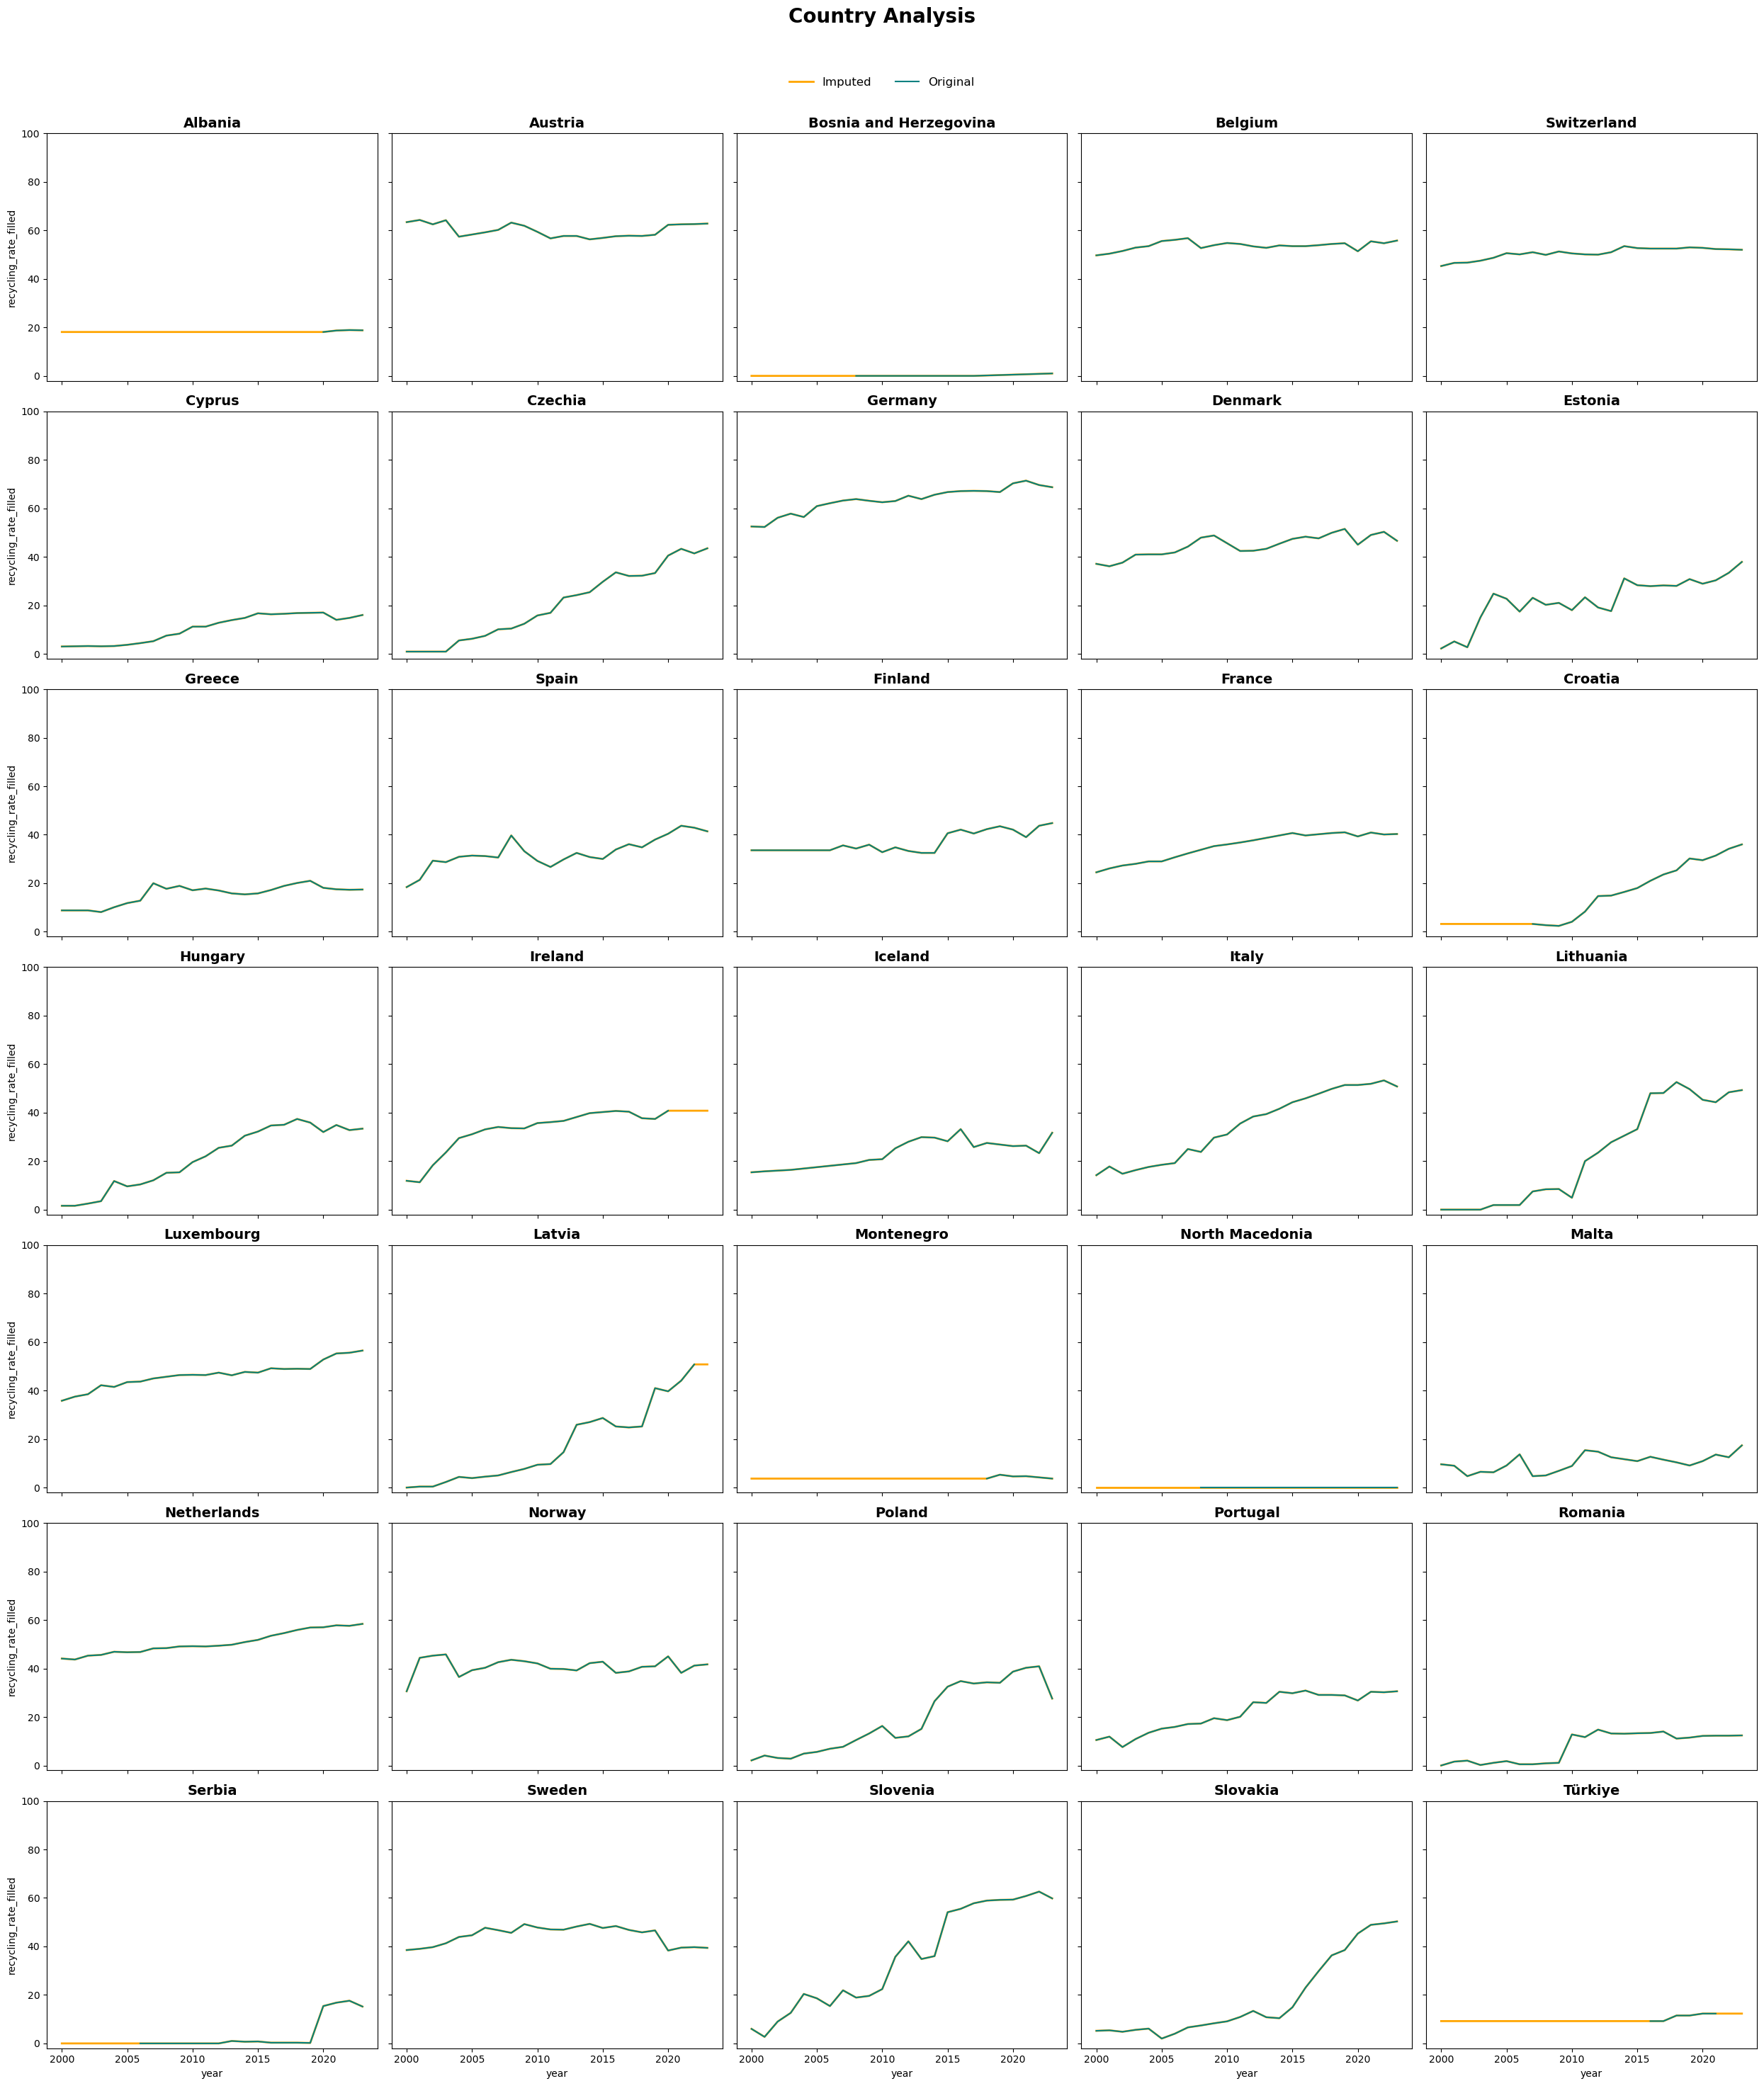

In [49]:
# Original vs imputed recycling rates
original_v_imputed = {
    'recycling_rate_filled': {'color': 'orange', 'lw': 2, 'alpha': 0.6, 'label': 'Imputed'},
    'recycling_rate': {'color': 'teal', 'lw': 1.5, 'marker': 'o', 'ms': 4, 'label': 'Original'}
}

plot_country_dashboard(res_d1_d3, original_v_imputed, cols=5);

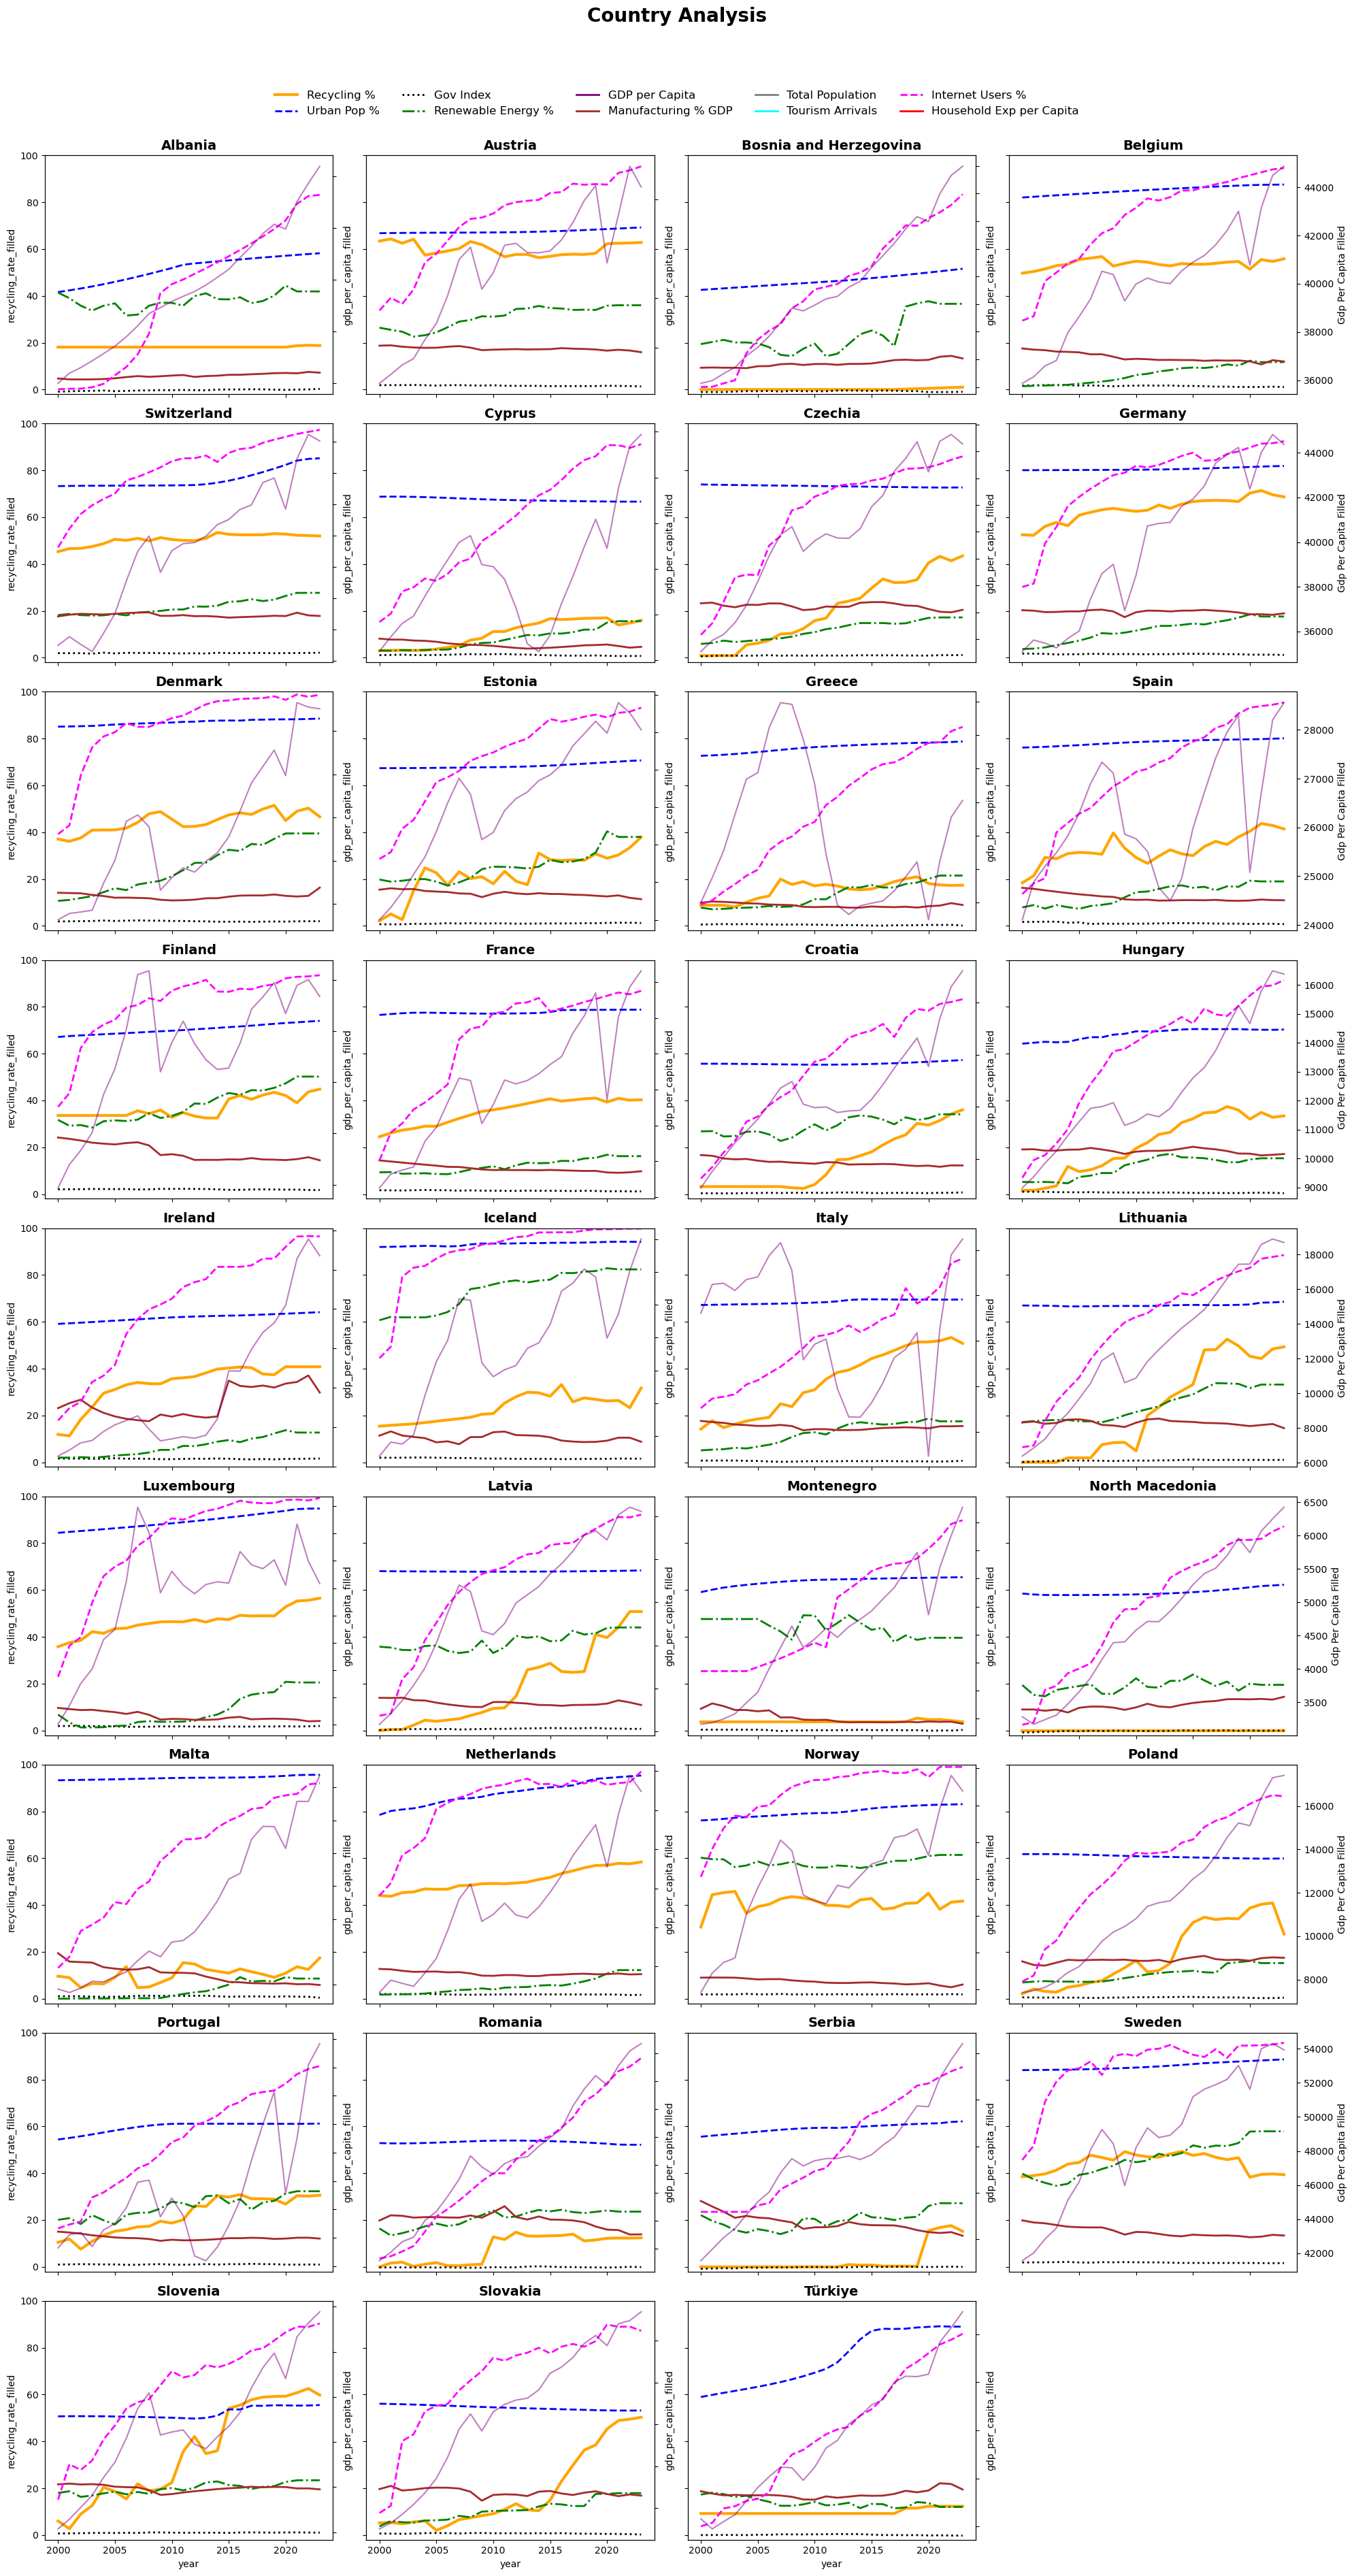

In [50]:
# Rescaling government effectiveness to 0-100 for better visualization since it is between -2.5 and 2.5
plot_df = res_d1_d3.copy()
plot_df['gov_effectiveness_index'] = ((plot_df['government_effectiveness_estimate_filled'] + 2.5) / 5 * 100)

# Primary metrics
metrics_config = {
    'recycling_rate_filled': {'color': 'orange', 'lw': 3, 'label': 'Recycling %'},
    'urban_population_pct_filled': {'color': 'blue', 'ls': '--', 'label': 'Urban Pop %'},
    'government_effectiveness_estimate_filled': {'color': 'black', 'ls': ':', 'label': 'Gov Index'},
    'renewable_energy_pct_filled': {'color': 'green', 'ls': '-.', 'label': 'Renewable Energy %'},
    'gdp_per_capita_filled': {'color': 'purple', 'ls': '-', 'label': 'GDP per Capita'},
    'manufacturing_value_added_pct_gdp_filled': {'color': 'brown', 'ls': '-', 'label': 'Manufacturing % GDP'},
    'population_total_filled': {'color': 'gray', 'ls': '-', 'label': 'Total Population'},
    'tourism_arrivals_filled': {'color': 'cyan', 'ls': '-', 'label': 'Tourism Arrivals'},
    'internet_users_pct_filled': {'color': 'magenta', 'ls': '--', 'label': 'Internet Users %'},
    'household_exp_percapita_filled': {'color': 'red', 'ls': '-', 'label': 'Household Exp per Capita'}
}

plot_country_dashboard(plot_df, metrics_config, secondary_metric='gdp_per_capita_filled');

The following graphs are the first ones to be included in the management summary. Because the data is so high-dimensional: many countries, years and variables, including all of it in a visualization makes it difficult to follow. Hence, we chose 5 countries in order to represent the case in different parts of the EU. We also plot the 2030 EU Recycling target to see how these countries compare against it.

All countries, except Sweden, show a steady increase in the recycling rates with Germany having met the target for several years now. In fact, Sweden even shows a decline in the recycling rates starting from 2020, possibly due to Covid-19. All countries show a plateau/slight decline in the years following Covid-19. This is likely due to the fact that the pandemic required a large number of resources, that had to be diverted elsewhere.

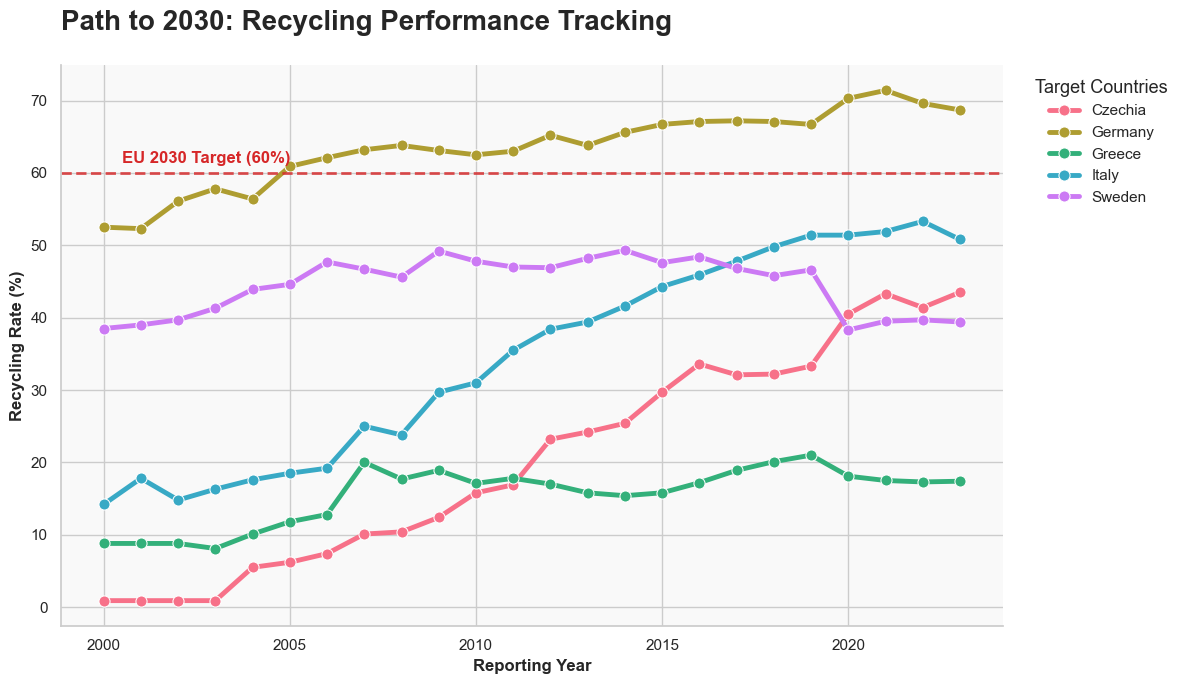

In [52]:
# Selecting 5 target countries for the management summary
targets = ['Germany', 'Sweden', 'Italy', 'Czechia', 'Greece']
df_subset = res_d1_d3[res_d1_d3['country_name'].isin(targets)].copy()

sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#f9f9f9"})
plt.figure(figsize=(12, 7))

palette = sns.color_palette("husl", len(targets))

line_plot = sns.lineplot(
    data=df_subset, 
    x='year', 
    y='recycling_rate_filled', 
    hue='country_name', 
    linewidth=3.5,
    marker='o',
    markersize=8,
    markeredgecolor='white',
    palette=palette
)

# EU 2030 target line
plt.axhline(y=60, color='#d62728', linestyle='--', linewidth=2, alpha=0.8)

plt.text(2000.5, 61, 'EU 2030 Target (60%)', color='#d62728', 
         fontweight='bold', fontsize=12, va='bottom')

plt.title("Path to 2030: Recycling Performance Tracking", 
          fontsize=20, fontweight='bold', pad=25, loc='left')


plt.ylabel("Recycling Rate (%)", fontsize=12, fontweight='bold')
plt.xlabel("Reporting Year", fontsize=12, fontweight='bold')

plt.legend(title="Target Countries", title_fontsize='13', 
           fontsize='11', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

sns.despine()

plt.tight_layout()

plt.savefig("../recycling-in-europe/figures/recycling_performance_2030.png", dpi=300, bbox_inches="tight")

plt.show()

Then, we move on to correlation analysis between the variables. This is important for several reasons, first it gives a preliminary overview which variables might be more important in our analysis. Second, it gives an overview of multicollinearity in the data that is important for modelling and regularization.

The graph shows that variables such as government effectiveness and percentage of internet users are strong drivers of recycling rates. Surprisingly, the percentage of renewable energy being utilized does not show a high correlation coefficient. Of course, it is important to not that correlation does not imply causation, and that this is just the preliminary step to obtain an overview.

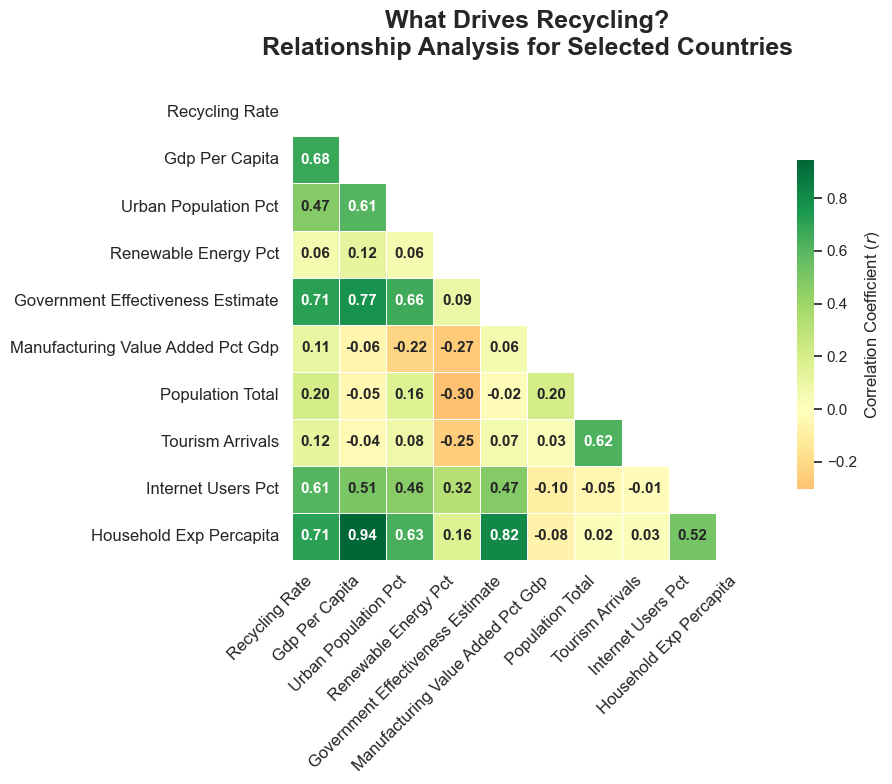

In [54]:
# Correlation analysis to identify drivers of recycling rates
core_indicators = [
    'recycling_rate_filled',
    'gdp_per_capita_filled',
    'urban_population_pct_filled',
    'renewable_energy_pct_filled',
    'government_effectiveness_estimate_filled',
    'manufacturing_value_added_pct_gdp_filled',
    'population_total_filled',
    'tourism_arrivals_filled',
    'internet_users_pct_filled',
    'household_exp_percapita_filled']

sns.set_theme(style="white")
plt.figure(figsize=(10, 8))

df_corr = res_d1_d3[core_indicators].corr()
df_corr.columns = [c.replace('_filled', '').replace('_', ' ').title() for c in df_corr.columns]
df_corr.index = [i.replace('_filled', '').replace('_', ' ').title() for i in df_corr.index]


mask = np.triu(np.ones_like(df_corr, dtype=bool))

sns.heatmap(
    df_corr, 
    mask=mask, 
    annot=True, 
    fmt=".2f", 
    cmap='RdYlGn', 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .7, "label": "Correlation Coefficient ($r$)"},
    annot_kws={"size": 11, "weight": "bold"}
)

plt.title("What Drives Recycling?\nRelationship Analysis for Selected Countries", 
          fontsize=18, pad=25, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()

plt.savefig("../recycling-in-europe/figures/recycling_drivers_correlation.png", dpi=300, bbox_inches="tight")

plt.show()

Now, we move on to more specific recycling data that is broken down by material profile: wood, plastic, paper, packaging, metallic, glass. One of the most dramatic elements to be noticed immediately is that the recycling rate of plastic for Sweden went down dramatically to 28.6%. This is important in order to understand exactly which parts of the recycling industry have imporoved and where.

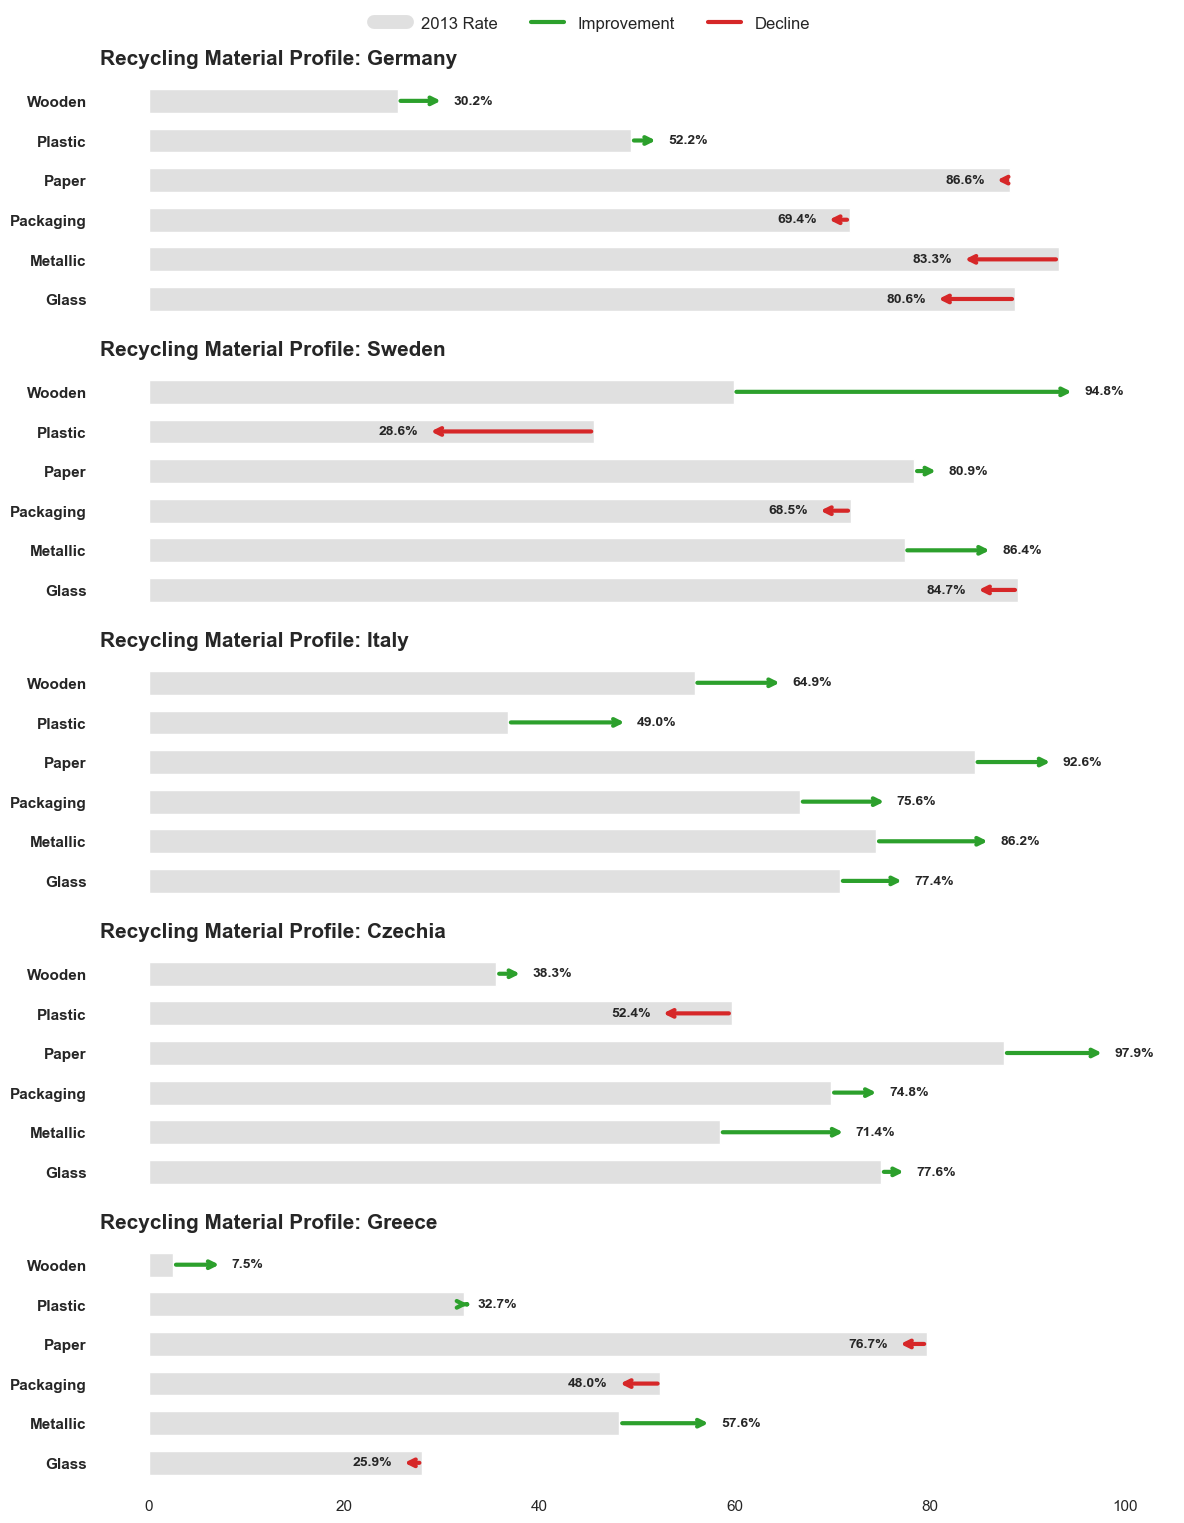

In [55]:
# Selecting the same 5 target countries for horizontal comparison
targets = ['Germany', 'Sweden', 'Italy', 'Czechia', 'Greece']
latest_year = res_d2_d3['year'].max()
material_cols = [c for c in res_d2_d3.columns if 'recycling_rate_filled_' in c]
material_labels = [m.replace('recycling_rate_filled_', '').title() for m in material_cols]

fig, axes = plt.subplots(len(targets), 1, figsize=(12, len(targets) * 3), sharex=True)
sns.set_theme(style="whitegrid")

for i, country in enumerate(targets):
    ax = axes[i]

    # extract data points
    d2013 = res_d2_d3[
        (res_d2_d3['country_name'] == country) & (res_d2_d3['year'] == 2013)
    ][material_cols].values.flatten()

    dLatest = res_d2_d3[
        (res_d2_d3['country_name'] == country) & (res_d2_d3['year'] == latest_year)
    ][material_cols].values.flatten()

    y_pos = np.arange(len(material_labels))

    # 2013 baseline
    ax.barh(y_pos, d2013, color='#e0e0e0', label='2013 Rate', height=0.6)

    # arrows for change
    for j, (start, end) in enumerate(zip(d2013, dLatest)):
        color = '#2ca02c' if end >= start else '#d62728'

        ax.annotate(
            '',
            xy=(end, j),
            xytext=(start, j),
            arrowprops=dict(
                arrowstyle='->',
                color=color,
                lw=3
            )
        )

    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(material_labels, fontweight='bold', fontsize=11)
    ax.set_title(
        f"Recycling Material Profile: {country}",
        fontsize=15,
        fontweight='bold',
        loc='left',
        pad=10
    )
    ax.set_xlim(-5, 105)

    # value labels
    for j, (start, end) in enumerate(zip(d2013, dLatest)):
        if end >= start:
            # improvement → label on the right
            x = end + 1
            ha = 'left'
        else:
            # decline → label on the left
            x = end - 1
            ha = 'right'

        ax.text(
            x, j,
            f"{end:.1f}%",
            va='center',
            ha=ha,
            fontsize=10,
            fontweight='bold'
        )


    sns.despine(left=True, bottom=True)


legend_elements = [
    Line2D([0], [0], color='#e0e0e0', lw=10, label='2013 Rate'),
    Line2D([0], [0], color='#2ca02c', lw=3, label='Improvement'),
    Line2D([0], [0], color='#d62728', lw=3, label='Decline')
]

fig.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=3,
    frameon=False,
    fontsize=12
)

plt.tight_layout()

plt.savefig("../recycling-in-europe/figures/recycling_material_profile_comparison.png", dpi=300, bbox_inches="tight")

plt.show()


# Statistical Analysis

### Data Aggregation & Selection

Data averaged over **2019–2023** to mitigate annual volatility. Luxembourg is excluded due to statistical leverage (outlier GDP).

**Variable Classification:**
* **Targets:** Dependent variables (Recycling rates).
* **Policy Drivers:** Modifiable independent variables (Taxes, Investment, Governance).
* **Context:** Structural/Control variables (GDP, Education, Urbanization).

In [ ]:
targets = [
    'recycling_rate',
    'recycling_rate_glass',
    'recycling_rate_metallic',
    'recycling_rate_packaging',
    'recycling_rate_paper',
    'recycling_rate_plastic',
    'recycling_rate_wooden'
]
policy_drivers = [
    'total_environm_tax_per_capita',
    'pollut_environm_tax_per_capita',
    'priv_inv_per_capita',
    'government_effectiveness_estimate'
]
context_vars = [
    'gdp_per_capita',
    'gr_val_add_per_capita',
    'urban_population_pct',
    'renewable_energy_pct',
    'highschool_completed_pct',
    'household_exp_percapita'
]

start_year = 2019
end_year = 2023

df_all = pd.read_csv('processed_data/preprocessed_all.csv')
df_recent = df_all[(df_all['year'] >= start_year) & (df_all['year'] <= end_year)].copy()

all_vars = targets + policy_drivers + context_vars
existing_cols = [c for c in all_vars if c in df_recent.columns]

df_avg = df_recent.groupby('country_name')[existing_cols].mean().reset_index()
df_avg = df_avg[df_avg['country_name'] != 'Luxembourg']
regression_cols = ['recycling_rate'] + policy_drivers
df_clean_regression = df_avg.dropna(subset=regression_cols).copy()

### Unsupervised Learning: Country Clustering

**K-Means clustering** stratifies countries based on economic power (`gdp_per_capita`), outcome (`recycling_rate`), and institutional capacity (`government_effectiveness_estimate`).

**Objective:**
Identify structural heterogeneity. The scatter plot reveals performance tiers relative to wealth, isolating "overachievers" from resource-rich underperformers.

In [ ]:
features_cluster = ['gdp_per_capita', 'recycling_rate', 'government_effectiveness_estimate']
X_cluster = df_clean_regression[features_cluster].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clean_regression['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_clean_regression,
    x='gdp_per_capita',
    y='recycling_rate',
    hue='cluster',
    palette='Set2',
    s=200,
    alpha=0.7,
    edgecolor='black',
    linewidth=1
)

key_countries = ['Austria', 'Germany', 'Belgium', 'Spain', 'Italy', 'Poland', 'Romania', 'Bulgaria']
for _, row in df_clean_regression.iterrows():
    if row['country_name'] in key_countries:
        plt.annotate(
            row['country_name'],
            xy=(row['gdp_per_capita'], row['recycling_rate']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            weight='bold'
        )

plt.title("Country Clusters: Wealth vs. Recycling Performance", fontsize=14, fontweight='bold')
plt.xlabel("GDP per Capita (€)")
plt.ylabel("General Recycling Rate (%)")
plt.grid(alpha=0.3)
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.savefig("./figures/country_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nCluster Profiles:")
print(df_clean_regression.groupby('cluster')[features_cluster].mean())

The clustering reveals that economic power is not the sole determinant of success. Cluster 1 combines high GDP (€53.5k) with strong governance (Index: 1.56) to maximize recycling (~52%). On the other hand, Cluster 0 and Cluster 2 share identical economic baselines (~€22k GDP) yet exhibit a 26.6% performance gap (41.3% vs. 14.7%).

This disparity tracks with Government Effectiveness (0.82 vs. 0.44), indicating that for middle-income nations, policy enforcement is a more critical driver than raw capital.

### Multivariate Regression (OLS)

Comparative OLS analysis quantifies driver impact. Two specifications are tested to resolve **multicollinearity**:

1.  **Full Model (10 vars):** High variance inflation; prone to overfitting.
2.  **Refined Model (5 vars):** Parsimonious selection representing distinct structural pillars:
    * *Economic:* **Private Investment** (Capital flow).
    * *Institutional:* **Government Effectiveness** (Enforcement capacity) and **Total Environment Tax** (Incentives by the government).
    * *Social:* **Education** (Compliance proxy).

**Visualization:** Standardized coefficients ($\beta$) allow direct magnitude comparison across predictors with different units.

In [ ]:
target = 'recycling_rate'
predictors_full = policy_drivers + context_vars
predictors_refined = [
    'priv_inv_per_capita',
    'total_environm_tax_per_capita',
    'government_effectiveness_estimate',
    'highschool_completed_pct'
]

X_full = df_clean_regression[predictors_full].copy()
y = df_clean_regression[target].copy()

X_full_std = (X_full - X_full.mean()) / X_full.std()
X_full_std = sm.add_constant(X_full_std)

model_full = sm.OLS(y, X_full_std).fit()

X_ref = df_clean_regression[predictors_refined].copy()
X_ref_std = (X_ref - X_ref.mean()) / X_ref.std()
X_ref_std = sm.add_constant(X_ref_std)

model_refined = sm.OLS(y, X_ref_std).fit()

print(f"Full model (10 vars)    -> R-squared Adj: {model_full.rsquared_adj:.3f} | AIC: {model_full.aic:.1f}")
print(f"Refined model (4 vars) -> R-squared Adj: {model_refined.rsquared_adj:.3f} | AIC: {model_refined.aic:.1f}")
print("\nWinning model: Refined model")
print(model_refined.summary())

coefs = model_refined.params.drop('const').sort_values()

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in coefs.values]

coefs.plot(kind='barh', ax=ax, color=colors, edgecolor='black', width=0.7)

ax.set_title("Key Drivers of Recycling Rate\n(Refined Model - Standardized Coefficients)", fontsize=14, fontweight='bold')
ax.set_xlabel("Effect Size (Std. Deviations increase in Recycling Rate per 1 SD in predictor)")
ax.axvline(0, color='black', linewidth=1, linestyle='--')

for index, value in enumerate(coefs):
    offset = 0.1 if value > 0 else -0.5
    ax.text(value + offset, index, f"{value:.2f}", va='center', fontweight='bold', color='#333333')

ax.grid(alpha=0.3, axis='x')
plt.tight_layout()

plt.savefig("./figures/refined_model_drivers.png", dpi=300, bbox_inches='tight')
plt.show()

The refined model (4 vars) reduces noise, improving Adjusted  (0.40 vs. 0.37) compared to the full specification. 

The key driver for recycling is **Private Investment** ($\beta=7.49$) and is the only statistically significant predictor ($p=0.05$), identifying capital allocation as the primary lever for recycling performance. Education contributes marginally ($\beta=4.56$); conversely, environmental taxes and government effectiveness show no independent statistical significance in this model.

### Bivariate Analysis: Fiscal Policy

Pearson correlation ($r$) assesses the relationship between taxation subtypes and recycling performance.

**Distinction:**
* **Total Environmental Tax:** Broad fiscal policy/infrastructure funding.
* **Pollution Tax:** Specific levies on emissions. often **reactive** measures in high-pollution contexts rather than preventative drivers.

In [ ]:
target = 'recycling_rate'
tax_vars = ['total_environm_tax_per_capita', 'pollut_environm_tax_per_capita']
df_tax = df_all[['country_name', 'year', target] + tax_vars].copy()

df_tax[tax_vars + [target]] = df_tax.groupby('country_name')[tax_vars + [target]].transform(
    lambda x: x.interpolate(limit_direction='both')
)
df_tax = df_tax.dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.regplot(x='total_environm_tax_per_capita', y='recycling_rate', data=df_tax, 
            ax=ax1, scatter_kws={'alpha':0.4, 'color':'tab:blue'}, line_kws={'color':'red'})

r_tot, p_tot = pearsonr(df_tax['total_environm_tax_per_capita'], df_tax['recycling_rate'])
ax1.set_title(f'Total Environmental Tax Impact\nR = {r_tot:.2f} (p={p_tot:.3f})', fontsize=12, fontweight='bold')
ax1.set_xlabel('Total Environmental Tax (€ per capita)')
ax1.set_ylabel('Recycling Rate (%)')
ax1.grid(alpha=0.3)

sns.regplot(x='pollut_environm_tax_per_capita', y='recycling_rate', data=df_tax, 
            ax=ax2, scatter_kws={'alpha':0.4, 'color':'tab:green'}, line_kws={'color':'darkgreen'})

r_pol, p_pol = pearsonr(df_tax['pollut_environm_tax_per_capita'], df_tax['recycling_rate'])
ax2.set_title(f'Pollution Tax Impact\nR = {r_pol:.2f} (p={p_pol:.3f})', fontsize=12, fontweight='bold')
ax2.set_xlabel('Pollution Environmental Tax (€ per capita)')
ax2.set_ylabel('')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("./figures/tax_correlation_comparison.png", dpi=300)
plt.show()

Data reveals that direct pollution taxes comprise a minor share of fiscal policy. High performers like Germany maintain low direct levies despite superior recycling outcomes.
The weak positive association $(R=0.26)$ contrasts with broader environmental taxation $(R=0.68)$, indicating that pollution-specific levies are currently under-leveraged compared to general infrastructure funding.

As a policy recommendation, there is significant scope to implement targeted pollution taxes. Shifting fiscal pressure from general revenue to specific behavioral penalties represents an unexploited mechanism to further accelerate circular transition. The green line shows the correlation for those countries that do implement said taxes.

# Dataset preparation for recycling rate prediction

In [ ]:
countries_to_drop = [
    "Bosnia and Herzegovina",
    "Montenegro",
    "North Macedonia",
    "Türkiye",
    "Serbia",
    "Albania"
]

res_d1_d3 = res_d1_d3[
    ~res_d1_d3["country_name"].isin(countries_to_drop)
].copy()

display(res_d1_d3)
sorted(res_d1_d3["country_name"].unique())


In [ ]:
def build_horizon_delta_dataset(
    df,
    horizon=7,
    start_year=2000,
    end_year=None,
    target_col="recycling_rate_filled",
    feature_cols=None
):
    """
    Builds a dataset where the target is the change in target_col over `horizon` years.
    """

    if end_year is None:
        end_year = df["year"].max() - horizon

    # anchor data (t)
    df_t = df[
        (df["year"] >= start_year) &
        (df["year"] <= end_year)
    ][["country_name", "year"] + feature_cols].copy()

    # future data (t + horizon)
    df_t_future = df[
        (df["year"] >= start_year + horizon) &
        (df["year"] <= end_year + horizon)
    ][["country_name", "year", target_col]].copy()

    df_t_future["year"] -= horizon

    # merge
    merged = df_t.merge(
        df_t_future,
        on=["country_name", "year"],
        how="inner",
        suffixes=("", "_future")
    )

    # delta target
    merged[f"delta_{target_col}_{horizon}yr"] = (
        merged[f"{target_col}_future"] - merged[target_col]
    )

    return merged


In [ ]:
feature_cols = [
    "recycling_rate_filled",
    "gdp_per_capita_filled",
    "urban_population_pct_filled",
    "internet_users_pct_filled",
    "renewable_energy_pct_filled",
    "tourism_arrivals_filled",
    "population_total_filled",
    "manufacturing_value_added_pct_gdp_filled",
    "government_effectiveness_estimate_filled",
    "highschool_completed_pct_filled",
    "household_exp_percapita_filled"
]

# build dataset with horizon recycling rates (in 7 years)
df_7yr = build_horizon_delta_dataset(
    feature_cols = feature_cols,
    df=res_d1_d3,
    horizon=7
)

display(df_7yr)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df_7yr["delta_recycling_rate_filled_7yr"], bins=30)
plt.xlabel("7-year change in recycling rate")
plt.ylabel("Frequency")
plt.title("Distribution of 7-year recycling rate changes")
plt.show()

## Check for diminsihing returns 

We want to check that higher starting rate → smaller improvement

In [ ]:
plt.scatter(
    df_7yr["recycling_rate_filled"],
    df_7yr["delta_recycling_rate_filled_7yr"],
    alpha=0.5
)
plt.xlabel("Initial recycling rate")
plt.ylabel("7-year change")
plt.title("Diminishing returns check")
plt.show()

## Split the data for delta = 7

In [ ]:
# Create training and validation/test datasets
train_df = df_7yr[df_7yr["year"] <= 2012].copy()
val_df   = df_7yr[df_7yr["year"] > 2012].copy()

In [ ]:
# Defining feature and target variables
target = "delta_recycling_rate_filled_7yr"

X_train = train_df[feature_cols]
y_train = train_df[target]

X_val = val_df[feature_cols]
y_val = val_df[target]

## Baseline Model: Linear regression (with regularization)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# Build a regression pipeline that scales features and fits a Ridge regression model
baseline_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

baseline_model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Generate predictions on validation set and evaluate model performance using MAE and R²
y_pred = baseline_model.predict(X_val)

print("MAE:", mean_absolute_error(y_val, y_pred))
print("R²:", r2_score(y_val, y_pred))

In [ ]:
# Check coefficients of the regression model
coefs = pd.Series(
    baseline_model.named_steps["model"].coef_,
    index=X_train.columns
).sort_values()

coefs

In [ ]:
# Plot predicted over actual 7-year change
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         "--", color="black")
plt.xlabel("Actual 7-year change")
plt.ylabel("Predicted 7-year change")
plt.title("Validation: Predicted vs Actual")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor
)

# Define helper functions
def evaluate_model(model, X_train, y_train, X_val, y_val, name="model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    return mae, r2, model, preds

def cast_int_or_none(x):
    return None if pd.isna(x) else int(x)

## Non-linear Model: Random Forest

In [ ]:
# Define basline RF model 
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)

rf_mae, rf_r2, _, _ = evaluate_model(rf_model, X_train, y_train, X_val, y_val)

print("RF Baseline MAE:", rf_mae)
print("RF Baseline R²:", rf_r2)

In [ ]:
# Manual tuning to optimize hyperparameters (n_estimators, max_depth, min_samples_leaf, min_samples_split, max_features)
results = []

for n_estimators in [200, 400, 800]:
    for max_depth in [None, 8, 12]:
        for min_leaf in [1, 2, 4]:
            for min_split in [2, 5, 10]:
                for max_feat in ["sqrt", "log2", None]:

                    rf = RandomForestRegressor(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_leaf=min_leaf,
                        min_samples_split=min_split,
                        max_features=max_feat,
                        random_state=42,
                    )

                    mae, r2, _, _ = evaluate_model(rf, X_train, y_train, X_val, y_val)

                    results.append({
                        "n_estimators": n_estimators,
                        "max_depth": max_depth,
                        "min_samples_leaf": min_leaf,
                        "min_samples_split": min_split,
                        "max_features": max_feat,
                        "MAE": mae,
                        "R2": r2
                    })

rf_results = pd.DataFrame(results).sort_values("MAE")

rf_results

In [ ]:
# Investigate best performing RF model (MAE, R2 & Importances)
best_rf = RandomForestRegressor(
    n_estimators=rf_results.iloc[0]["n_estimators"],
    max_depth=cast_int_or_none(rf_results.iloc[0]["max_depth"]),
    min_samples_leaf=rf_results.iloc[0]["min_samples_leaf"],
    min_samples_split=rf_results.iloc[0]["min_samples_split"],
    max_features=rf_results.iloc[0]["max_features"],
    random_state=42,
)

best_rf_mae, best_rf_r2, best_rf, best_rf_preds = evaluate_model(best_rf, X_train, y_train, X_val, y_val)

print("Best RF MAE:", best_rf_mae)
print("Best RF R²:", best_rf_r2)

plt.scatter(y_val, best_rf_preds, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         "--", color="black")
plt.xlabel("Actual 7-year change")
plt.ylabel("Predicted 7-year change")
plt.title("Validation: Predicted vs Actual")
plt.show()

importances = pd.Series(best_rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances)

## Non-linear Model: Gradient Boosting

In [ ]:
# Define baseline Gradient Boosting model
gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

gbr_mae, gbr_r2, _, _ = evaluate_model(gbr, X_train, y_train, X_val, y_val)

print("GBR Baseline MAE:", gbr_mae)
print("GBR Baseline R²:", gbr_r2)

In [ ]:
# Manual tuning to optimize hyperparameters (n_estimators, learning_rate, max_depth, min_samples_leaf, subsample)

gbr_results = []

for n_estimators in [200, 400, 800]:
    for learning_rate in [0.03, 0.05, 0.1]:
        for max_depth in [2, 3, 4]:
            for min_leaf in [1, 3, 5]:
                for subsample in [0.7, 0.9, 1.0]:

                    gbr = GradientBoostingRegressor(
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        min_samples_leaf=min_leaf,
                        subsample=subsample,
                        random_state=42
                    )
                    
                    mae, r2, _, _ = evaluate_model(gbr, X_train, y_train, X_val, y_val)

                    gbr_results.append({
                        "n_estimators": n_estimators,
                        "learning_rate": learning_rate,
                        "max_depth": max_depth,
                        "min_samples_leaf": min_leaf,
                        "subsample": subsample,
                        "MAE": mae,
                        "R2": r2
                    })

gbr_results_df = (
    pd.DataFrame(gbr_results)
    .sort_values("MAE")
    .reset_index(drop=True)
)

gbr_results_df

In [ ]:
# Investigate best performing GBR model (MAE, R2 & Importances)

best_gbr = GradientBoostingRegressor(
    n_estimators=cast_int_or_none(gbr_results_df.iloc[0]["n_estimators"]),
    learning_rate=gbr_results_df.iloc[0]["learning_rate"],
    max_depth=cast_int_or_none(gbr_results_df.iloc[0]["max_depth"]),
    min_samples_leaf=cast_int_or_none(gbr_results_df.iloc[0]["min_samples_leaf"]),
    subsample=gbr_results_df.iloc[0]["subsample"],
    random_state=42,
)

best_gbr_mae, best_gbr_r2, best_gbr, best_gbr_preds = evaluate_model(best_gbr, X_train, y_train, X_val, y_val)

print("Best GBR MAE:", best_gbr_mae)
print("Best GBR R²:", best_gbr_r2)

plt.scatter(y_val, best_gbr_preds, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         "--", color="black")
plt.xlabel("Actual 7-year change")
plt.ylabel("Predicted 7-year change")
plt.title("Validation: Predicted vs Actual")
plt.show()

importances = pd.Series(best_gbr.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances)

## Non-linear Model: Histogram-based Gradient Boosting

In [ ]:
# Define basemodel HGB model

hgb = HistGradientBoostingRegressor(
    loss="absolute_error",
    max_iter=300,
    learning_rate=0.05,
    random_state=42
)

hgb_mae, hgb_r2, _, _ = evaluate_model(hgb, X_train, y_train, X_val, y_val)


print("HGB Baseline MAE:", hgb_mae)
print("HGB Baseline R²:", hgb_r2)

In [ ]:
# Manual tuning to optimize hyperparameters (max_iter, learning_rate, max_depth, min_samples_leaf)

hgb_results = []

for max_iter in [300, 600, 1000]:
    for learning_rate in [0.03, 0.05, 0.1]:
        for max_depth in [3, 5, 7]:
            for min_samples_leaf in [10, 20, 40]:

                hgb = HistGradientBoostingRegressor(
                    max_iter=max_iter,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )

                mae, r2, _, _ = evaluate_model(hgb, X_train, y_train, X_val, y_val)

                hgb_results.append({
                    "max_iter": max_iter,
                    "learning_rate": learning_rate,
                    "max_depth": max_depth,
                    "min_samples_leaf": min_samples_leaf,
                    "MAE": mae,
                    "R2": r2
                })

hgb_results_df = (
    pd.DataFrame(hgb_results)
    .sort_values("MAE")
    .reset_index(drop=True)
)

hgb_results_df


In [ ]:
# Investigate best performing HGB model (MAE, R2)

best_hgb = HistGradientBoostingRegressor(
    max_iter=cast_int_or_none(hgb_results_df.iloc[0]["max_iter"]),
    learning_rate=hgb_results_df.iloc[0]["learning_rate"],
    max_depth=cast_int_or_none(hgb_results_df.iloc[0]["max_depth"]),
    min_samples_leaf=cast_int_or_none(hgb_results_df.iloc[0]["min_samples_leaf"]),
    random_state=42,
)

best_hgb_mae, best_hgb_r2, best_hgb, best_hgb_preds = evaluate_model(best_hgb, X_train, y_train, X_val, y_val)

print("Best HGB MAE:", best_hgb_mae)
print("Best hgb R²:", best_hgb_r2)

plt.scatter(y_val, best_hgb_preds, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         "--", color="black")
plt.xlabel("Actual 7-year change")
plt.ylabel("Predicted 7-year change")
plt.title("Validation: Predicted vs Actual")
plt.show()

## Non-linear Model: Extreme Gradient Boosting

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor

# Define Baseline XGB model
xgb = XGBRegressor(
    objective="reg:absoluteerror", 
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_mae, xgb_r2, _, _ = evaluate_model(xgb, X_train, y_train, X_val, y_val)

print("XGB Baseline MAE:", xgb_mae)
print("XGB Baseline R²:", xgb_r2)

In [ ]:
from xgboost import XGBRegressor
import pandas as pd

# Manual tuning to optimize hyperparameters (n_estimators, learning_rate, max_depth, subsample, colsample_bytree)

xgb_results = []

for n_estimators in [300, 600, 1000]:
    for learning_rate in [0.03, 0.05, 0.1]:
        for max_depth in [3, 4, 5]:
            for subsample in [0.7, 0.9, 1.0]:
                for colsample in [0.7, 0.9, 1.0]:

                    xgb = XGBRegressor(
                        n_estimators=n_estimators,
                        learning_rate=learning_rate,
                        max_depth=max_depth,
                        subsample=subsample,
                        colsample_bytree=colsample,
                        random_state=42,
                    )

                    mae, r2, _, _ = evaluate_model(xgb, X_train, y_train, X_val, y_val)


                    xgb_results.append({
                        "n_estimators": n_estimators,
                        "learning_rate": learning_rate,
                        "max_depth": max_depth,
                        "subsample": subsample,
                        "colsample_bytree": colsample,
                        "MAE": mae,
                        "R2": r2
                    })

xgb_results_df = (
    pd.DataFrame(xgb_results)
    .sort_values("MAE")
    .reset_index(drop=True)
)

xgb_results_df

In [ ]:
# Investigate best performing XGB model (MAE, R2 & Importances)

best_xgb = XGBRegressor(
    n_estimators=cast_int_or_none(xgb_results_df.iloc[0]["n_estimators"]),
    learning_rate=xgb_results_df.iloc[0]["learning_rate"],
    max_depth=cast_int_or_none(xgb_results_df.iloc[0]["max_depth"]),
    subsample=xgb_results_df.iloc[0]["subsample"],
    colsample_bytree=xgb_results_df.iloc[0]["colsample_bytree"],
    random_state=42,
)

best_xgb_mae, best_xgb_r2, best_xgb, best_xgb_preds = evaluate_model(best_xgb, X_train, y_train, X_val, y_val)

print("Best XGB MAE:", best_xgb_mae)
print("Best XGB R²:", best_xgb_r2)

plt.scatter(y_val, best_xgb_preds, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         "--", color="black")
plt.xlabel("Actual 7-yeaxr change")
plt.ylabel("Predicted 7-year change")
plt.title("Validation: Predicted vs Actual")
plt.show()

importances = pd.Series(best_xgb.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances)

## Would we see better MAE with 5 years delta (instead of 7)? 

In [ ]:
# Resplitting dataset for delta of 5 years

df_5yr = build_horizon_delta_dataset(
    feature_cols=feature_cols,
    df=res_d1_d3,
    horizon=5
)

train_df_5 = df_5yr[df_5yr["year"] <= 2014]
val_df_5   = df_5yr[df_5yr["year"] > 2014]

target_5 = "delta_recycling_rate_filled_5yr"

X_train_5 = train_df_5[feature_cols]
y_train_5 = train_df_5[target_5]

X_val_5 = val_df_5[feature_cols]
y_val_5 = val_df_5[target_5]

# Evaluatign previous optimized models for delta of 5 years
best_rf_5_mae , best_rf_5_r2, _, _ = evaluate_model(best_rf,  X_train_5, y_train_5, X_val_5, y_val_5, "RF (5yr)")
best_gbr_5_mae , best_gbr_5_r2, _, _ =evaluate_model(best_gbr, X_train_5, y_train_5, X_val_5, y_val_5, "GBR (5yr)")
best_hgb_5_mae , best_hgb_5_r2, _, _ =evaluate_model(best_hgb, X_train_5, y_train_5, X_val_5, y_val_5, "HGB (5yr)")
best_xgb_5_mae , best_xgb_5_r2, _, _ =evaluate_model(best_xgb, X_train_5, y_train_5, X_val_5, y_val_5, "XGB (5yr)")

results_5yr = {
    "RF (5yr)": (best_rf_5_mae, best_rf_5_r2),
    "GBR (5yr)": (best_gbr_5_mae, best_gbr_5_r2),
    "HGB (5yr)": (best_hgb_5_mae, best_hgb_5_r2),
    "XGB (5yr)": (best_xgb_5_mae, best_xgb_5_r2),
}

for model, (mae, r2) in results_5yr.items():
    print(f"{model:10s} | MAE: {mae:.3f} | R²: {r2:.3f}")

Answer is no but we might need to retune the models for 5 years delta

# Predict recycling rates for dataset in 2030

In [ ]:
predictions__df = res_d1_d3[res_d1_d3["year"] == res_d1_d3["year"].max()].copy()

# Features for prediction
X_latest = predictions__df[feature_cols]

# Predict 7-year delta from latest year
predicted_delta = best_xgb.predict(X_latest)

# Compute projected 2030 rate
predictions__df["predicted_delta_2030"] = predicted_delta
predictions__df["predicted_rate_2030"] = predictions__df["recycling_rate_filled"] + predicted_delta

eu_target = 60 
predictions__df["meets_target"] = predictions__df["predicted_rate_2030"] >= eu_target

projection_2030 = predictions__df[
    ["country_name", "recycling_rate_filled", "predicted_delta_2030", "predicted_rate_2030", "meets_target"]
].sort_values("predicted_rate_2030", ascending=False).reset_index(drop=True)

projection_2030

In [ ]:
# show predicted deltas by 2030
plt.figure(figsize=(10,6))
sns.histplot(projection_2030["predicted_delta_2030"], bins=7, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Predicted 7-year increase in recycling rate")
plt.ylabel("Number of countries")
plt.title("Distribution of Predicted Recycling Rate Increase by 2030")
plt.show()

In [ ]:
# Show predicted final recycling rates by 2030

plt.figure(figsize=(10,6))
sns.histplot(projection_2030["predicted_rate_2030"], bins=9, kde=True, color='green')
plt.axvline(eu_target, color='red', linestyle='--', label=f'EU Target ({eu_target}%)')
plt.xlabel("Predicted recycling rate in 2030 (%)")
plt.ylabel("Number of countries")
plt.title("Distribution of Predicted Recycling Rates in 2030")
plt.legend()
plt.show()

In [ ]:
# Show Current vs preidcted recycling rates by 2030

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="recycling_rate_filled",
    y="predicted_rate_2030",
    hue="meets_target",
    data=projection_2030,
    palette={True: 'green', False: 'red'},
    s=100
)
plt.plot([0, 100], [0, 100], 'k--', alpha=0.7)  # diagonal
plt.xlabel("Current recycling rate (%)")
plt.ylabel("Predicted rate in 2030 (%)")
plt.title("Current vs Predicted Recycling Rates")
plt.show()

## Countries with biggest predicted improvements

In [ ]:
# Show countries with biggets predicted improvements 
top_increases = projection_2030.sort_values("predicted_delta_2030", ascending=False).head(10)
top_increases[["country_name", "recycling_rate_filled", "predicted_delta_2030", "predicted_rate_2030"]]

## Countries by outcome analysis

In [ ]:
# Show most contriubting variables to recycling rates deltas
importances = best_xgb.feature_importances_
feat_imp_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp_df, palette="viridis")
plt.title("Global Feature Importance (XGBoost)")
plt.show()

In [ ]:
!pip install shap

In [ ]:
import shap

explainer = shap.Explainer(best_xgb, X_latest)
shap_values = explainer(X_latest)

# Global summary
shap.summary_plot(shap_values, X_latest, feature_names=feature_cols)

# Mean absolute SHAP value per feature
shap_df = pd.DataFrame({
    "feature": feature_cols,
    "mean_abs_shap": np.abs(shap_values.values).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)

print(shap_df)



In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Split dataset into achievers and non-achievers
achievers = predictions__df[predictions__df["meets_target"]].copy()
non_achievers = predictions__df[~predictions__df["meets_target"]].copy()

# Determine grid size
n_features = len(feature_cols)
n_cols = 3 
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  # flatten for easy indexing

for i, feature in enumerate(feature_cols):
    sns.kdeplot(achievers[feature], label="Achievers", fill=True, ax=axes[i])
    sns.kdeplot(non_achievers[feature], label="Non-Achievers", fill=True, ax=axes[i])
    axes[i].set_title(f"{feature} distribution")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Density")
    axes[i].legend()

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
